<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/FINAL_CX_CB_RUN_4_IPYNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# CELL 1: Complete Environment Setup
import sys
import torch
import psutil
import warnings
warnings.filterwarnings('ignore')

# System check
print(f"Python: {sys.version}")
print(f"Colab: {'google.colab' in sys.modules}")

# GPU check
!nvidia-smi
GPU_AVAILABLE = torch.cuda.is_available()
if GPU_AVAILABLE:
    device = torch.device("cuda")
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device("cpu")
    print("✗ Using CPU")

# Memory check
available_ram_gb = psutil.virtual_memory().available / 1e9
total_ram_gb = psutil.virtual_memory().total / 1e9
HIGH_MEMORY = available_ram_gb > 16
print(f"✓ RAM: {available_ram_gb:.1f}/{total_ram_gb:.1f} GB ({'HIGH' if HIGH_MEMORY else 'LOW'} memory)")

# Install packages (only what's needed)
!pip install -q numpy==1.26.4  # Fix numpy version
!pip install -q xgboost lightgbm catboost  # Boosting libraries
!pip install -q scikit-learn pandas matplotlib seaborn  # Core ML

print("\n✅ Environment ready")

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Colab: True
Tue Sep 23 21:07:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        | 

In [3]:
# CELL 2: Exhaustive pip installs for all 47 ML models + baseline


# Core ML libraries (our models)
!pip install -q xgboost      # For XGBoost_V1, XGBoost_V2
!pip install -q lightgbm     # For LightGBM_V1, LightGBM_VP
!pip install -q catboost     # For CatBoost_V1, CatBoost_VP

# Additional useful packages
!pip install -q scikit-learn --upgrade  # Ensure latest sklearn for HistGradientBoostingRegressor
!pip install -q pandas numpy matplotlib seaborn  # Data handling and visualization
!pip install -q tqdm  # Progress bars for long runs

# These are from original notebook but NOT needed for our ML models:
# !pip install tensorflow  # Not using TF for our models
# !pip install tbats      # Time series specific - not needed
# !pip install pmdarima   # Time series specific - not needed

print("✓ All packages for 47 ML models installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.3 MB/s eta 0:00:00
✓ All packages for 47 ML models installed


In [6]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
# CELL 2.5: Import All Libraries and Check Availability
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Track what's available
AVAILABLE_MODELS = {'base': True}  # sklearn is always available

# Core sklearn
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor,
                             GradientBoostingRegressor, BaggingRegressor,
                             AdaBoostRegressor, VotingRegressor, StackingRegressor,
                             HistGradientBoostingRegressor)
from sklearn.linear_model import (Ridge, Lasso, ElasticNet, HuberRegressor,
                                  BayesianRidge, ARDRegression)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
print("✓ Sklearn models loaded")

# Optional libraries
try:
    import xgboost as xgb
    AVAILABLE_MODELS['xgboost'] = True
    print("✓ XGBoost available")
except:
    AVAILABLE_MODELS['xgboost'] = False
    print("✗ XGBoost not available")

try:
    import lightgbm as lgb
    AVAILABLE_MODELS['lightgbm'] = True
    print("✓ LightGBM available")
except:
    AVAILABLE_MODELS['lightgbm'] = False
    print("✗ LightGBM not available")

try:
    import catboost as cb
    AVAILABLE_MODELS['catboost'] = True
    print("✓ CatBoost available")
except:
    AVAILABLE_MODELS['catboost'] = False
    print("✗ CatBoost not available")

print(f"\nTotal available model types: {sum(AVAILABLE_MODELS.values())}/4")

✓ Sklearn models loaded
✓ XGBoost available
✓ LightGBM available
✓ CatBoost available

Total available model types: 4/4


In [2]:
# CELL 3: Enhanced imports with debugging setup (following notebook structure)
import pandas as pd
import numpy as np
import warnings
import time
import logging
import sys
import traceback
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple, Any, Union
from dataclasses import dataclass
import itertools

# Configure comprehensive logging for notebook visibility
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)
logger.info("DEBUG LOGGING INITIALIZED")

# Core ML imports
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# Tree-based models
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
                             BaggingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor,
                             HistGradientBoostingRegressor)
from sklearn.tree import DecisionTreeRegressor

# Check optional libraries with detailed reporting
logger.info("Checking optional ML libraries...")

XGB_AVAILABLE = False
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    logger.info(f"XGBoost available: {xgb.__version__}")
except ImportError:
    logger.warning("XGBoost not available")

LGB_AVAILABLE = False
try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    logger.info(f"LightGBM available: {lgb.__version__}")
except ImportError:
    logger.warning("LightGBM not available")

CATBOOST_AVAILABLE = False
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
    logger.info(f"CatBoost available: {cb.__version__}")
except ImportError:
    logger.warning("CatBoost not available")

# Linear models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, ARDRegression, HuberRegressor,
    SGDRegressor, PassiveAggressiveRegressor
)

# Neural networks
from sklearn.neural_network import MLPRegressor

# Other models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

# Suppress sklearn warnings but keep our logging
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set reproducible seed
np.random.seed(42)

logger.info("All imports completed successfully")
print(f"\nLIBRARY STATUS:")
print(f"  XGBoost: {'✅' if XGB_AVAILABLE else '❌'}")
print(f"  LightGBM: {'✅' if LGB_AVAILABLE else '❌'}")
print(f"  CatBoost: {'✅' if CATBOOST_AVAILABLE else '❌'}")


LIBRARY STATUS:
  XGBoost: ✅
  LightGBM: ✅
  CatBoost: ✅


In [3]:
# CELL 4: Configuration for our ML models + baseline
import psutil

# Check memory availability for this cell
available_ram_gb = psutil.virtual_memory().available / 1e9
HIGH_MEMORY = available_ram_gb > 16

@dataclass
class DebugMLForecastingConfig:
    """Configuration for general-purpose ML pipeline"""

    # Data parameters
    target_column: str = "calls"
    date_column: str = "date"
    test_split_ratio: float = 0.75
    validation_split_ratio: float = 0.15

    # Feature engineering
    max_lags: int = 14
    rolling_windows: List[int] = None
    create_technical_indicators: bool = True
    create_calendar_features: bool = True

    # Model families to use
    use_tree_models: bool = True
    use_linear_models: bool = True
    use_neural_models: bool = True
    use_ensemble_models: bool = True
    use_other_models: bool = True
    use_gradient_boosting: bool = True

    # Version control
    run_v1_models: bool = True
    run_v2_models: bool = True
    run_vp_optimization: bool = True

    # GridSearchCV parameters
    cv_splits: int = 3
    parallel_jobs: int = 1  # Single job for debugging
    scoring_metric: str = 'neg_mean_absolute_error'
    gridsearch_verbose: int = 2

    # Optimization settings
    quick_search: bool = False
    detailed_search: bool = True
    top_models_for_optimization: int = 5

    # Debug settings
    debug_mode: bool = True
    show_progress: bool = True
    time_each_phase: bool = True
    save_intermediate_results: bool = True

    def __post_init__(self):
        # Check memory locally
        available_ram_gb = psutil.virtual_memory().available / 1e9
        high_memory = available_ram_gb > 16

        if self.rolling_windows is None:
            if high_memory:
                self.rolling_windows = [3, 7, 14, 21]
                self.max_lags = 21
            else:
                self.rolling_windows = [3, 7, 14]
                self.max_lags = 14

        logger.info(f"Configuration initialized:")
        logger.info(f"  Target: {self.target_column}")
        logger.info(f"  Max lags: {self.max_lags}")
        logger.info(f"  Rolling windows: {self.rolling_windows}")
        logger.info(f"  V1/V2/VP phases: {self.run_v1_models}/{self.run_v2_models}/{self.run_vp_optimization}")

# Performance monitoring decorator
def monitor_performance(func_name: str = None):
    """Decorator to monitor function execution time"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            name = func_name or func.__name__
            start_time = time.time()
            logger.info(f"🚀 Starting {name}...")

            try:
                result = func(*args, **kwargs)
                duration = time.time() - start_time
                logger.info(f"✅ {name} completed in {duration:.1f}s")
                return result
            except Exception as e:
                duration = time.time() - start_time
                logger.error(f"❌ {name} failed after {duration:.1f}s: {str(e)}")
                raise
        return wrapper
    return decorator

print("Configuration and monitoring setup complete")

# Initialize config
config = DebugMLForecastingConfig()


Configuration and monitoring setup complete


In [4]:
# CELL 5: Base ML Forecaster with Enhanced Debugging
class DebugMLForecaster:
    """Enhanced ML forecaster with comprehensive debugging"""

    def __init__(self, name: str, model, debug_mode: bool = True):
        self.name = name
        self.model = clone(model)
        self.pipeline = None
        self.is_fitted = False
        self.feature_importance_ = None
        self.debug_mode = debug_mode
        self.training_time = None
        self.prediction_time = None
        self.fit_error = None

    def fit(self, X: pd.DataFrame, y: pd.Series) -> 'DebugMLForecaster':
        """Fit model with comprehensive error handling and timing"""

        fit_start = time.time()

        try:
            if self.debug_mode:
                logger.debug(f"Fitting {self.name} on data shape: {X.shape}")

            # Validate input data
            if X.empty or y.empty:
                raise ValueError(f"Empty input data for {self.name}")

            if len(X) != len(y):
                raise ValueError(f"Feature/target length mismatch for {self.name}: {len(X)} vs {len(y)}")

            # Convert to numpy arrays
            X_array = X.values if isinstance(X, pd.DataFrame) else X
            y_array = y.values if isinstance(y, pd.Series) else y

            # Check for NaN/inf values
            if np.any(np.isnan(X_array)) or np.any(np.isinf(X_array)):
                logger.warning(f"{self.name}: Found NaN/inf in features, cleaning...")
                X_array = np.nan_to_num(X_array, nan=0.0, posinf=1e6, neginf=-1e6)

            if np.any(np.isnan(y_array)) or np.any(np.isinf(y_array)):
                logger.warning(f"{self.name}: Found NaN/inf in target, cleaning...")
                y_array = np.nan_to_num(y_array, nan=np.nanmean(y_array))

            # Create and fit pipeline
            self.pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', clone(self.model))
            ])

            # Fit with error handling
            self.pipeline.fit(X_array, y_array.ravel())
            self.is_fitted = True

            # Test prediction capability
            test_pred = self.pipeline.predict(X_array[:min(5, len(X_array))])
            if np.any(np.isnan(test_pred)) or np.any(np.isinf(test_pred)):
                logger.warning(f"{self.name}: Model produces invalid predictions")
                self.is_fitted = False

        except Exception as e:
            self.fit_error = str(e)
            logger.error(f"{self.name} fit failed: {self.fit_error}")
            self.is_fitted = False

        finally:
            self.training_time = time.time() - fit_start

            if self.debug_mode:
                status = "✅ SUCCESS" if self.is_fitted else "❌ FAILED"
                logger.info(f"{self.name}: {status} (Training time: {self.training_time:.2f}s)")

        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions with error handling"""

        if not self.is_fitted:
            logger.error(f"{self.name}: Cannot predict - model not fitted")
            return np.zeros(len(X))

        pred_start = time.time()

        try:
            X_array = X.values if isinstance(X, pd.DataFrame) else X

            # Clean input data
            if np.any(np.isnan(X_array)) or np.any(np.isinf(X_array)):
                X_array = np.nan_to_num(X_array, nan=0.0, posinf=1e6, neginf=-1e6)

            predictions = self.pipeline.predict(X_array)

            # Validate predictions
            if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                logger.warning(f"{self.name}: Invalid predictions detected, cleaning...")
                predictions = np.nan_to_num(predictions, nan=0.0, posinf=1e6, neginf=-1e6)

            self.prediction_time = time.time() - pred_start

            if self.debug_mode:
                logger.debug(f"{self.name}: Prediction completed in {self.prediction_time:.3f}s")

            return predictions.flatten()

        except Exception as e:
            self.prediction_time = time.time() - pred_start
            logger.error(f"{self.name} prediction failed: {str(e)}")
            return np.zeros(len(X))

    def get_info(self) -> Dict[str, Any]:
        """Get comprehensive model information"""
        return {
            'name': self.name,
            'is_fitted': self.is_fitted,
            'training_time': self.training_time,
            'prediction_time': self.prediction_time,
            'fit_error': self.fit_error
        }

logger.info("Enhanced ML Forecaster class loaded")

In [5]:
# CELL 6: Model Factory - Total: 39 models (with all libraries) or 33 models (without optional libraries)
class DebugMLModelFactory:
    """Model factory for creating all ML model variants"""

    @staticmethod
    @monitor_performance("Model Creation")
    def create_all_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create comprehensive set of ML models"""

        logger.info("🏭 Creating ML models...")
        all_models = []

        # Random Forest Family (6 models)
        if config.use_tree_models:
            logger.info("  Creating Random Forest family...")
            all_models.extend([
                DebugMLForecaster("V1_RandomForest", RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42), config.debug_mode),
                DebugMLForecaster("V2_RandomForest", RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42), config.debug_mode),
                DebugMLForecaster("RandomForest_Optimized", RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=42), config.debug_mode),
                DebugMLForecaster("RandomForest_VP", RandomForestRegressor(n_estimators=100, random_state=42), config.debug_mode),  # For GridSearch
                DebugMLForecaster("V1_ExtraTrees", ExtraTreesRegressor(n_estimators=50, max_depth=10, random_state=42), config.debug_mode),
                DebugMLForecaster("V2_ExtraTrees", ExtraTreesRegressor(n_estimators=100, max_depth=None, random_state=42), config.debug_mode),
            ])

        # Gradient Boosting Family (11 models)
        if config.use_gradient_boosting:
            logger.info("  Creating Gradient Boosting family...")
            all_models.extend([
                DebugMLForecaster("V1_GradientBoosting", GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42), config.debug_mode),
                DebugMLForecaster("V2_GradientBoosting", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42), config.debug_mode),
                DebugMLForecaster("GradientBoosting_Optimized", GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42), config.debug_mode),
                DebugMLForecaster("GradientBoosting_VP", GradientBoostingRegressor(n_estimators=100, random_state=42), config.debug_mode),
                DebugMLForecaster("HistGradientBoosting", HistGradientBoostingRegressor(max_iter=100, random_state=42), config.debug_mode),
            ])

            # XGBoost if available
            if XGB_AVAILABLE:
                all_models.extend([
                    DebugMLForecaster("XGBoost_V1", xgb.XGBRegressor(n_estimators=50, random_state=42), config.debug_mode),
                    DebugMLForecaster("XGBoost_V2", xgb.XGBRegressor(n_estimators=100, random_state=42), config.debug_mode),
                ])

            # LightGBM if available
            if LGB_AVAILABLE:
                all_models.extend([
                    DebugMLForecaster("LightGBM_V1", lgb.LGBMRegressor(n_estimators=50, random_state=42, verbose=-1), config.debug_mode),
                    DebugMLForecaster("LightGBM_VP", lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1), config.debug_mode),
                ])

            # CatBoost if available
            if CATBOOST_AVAILABLE:
                all_models.extend([
                    DebugMLForecaster("CatBoost_V1", cb.CatBoostRegressor(iterations=50, random_state=42, verbose=False), config.debug_mode),
                    DebugMLForecaster("CatBoost_VP", cb.CatBoostRegressor(iterations=100, random_state=42, verbose=False), config.debug_mode),
                ])

        # Linear & Regularized Models (10 models)
        # NOTE: Ridge, BayesianRidge, HuberRegressor do NOT have random_state
        # Only Lasso and ElasticNet have random_state (for selection='random')
        if config.use_linear_models:
            logger.info("  Creating Linear family...")
            all_models.extend([
                DebugMLForecaster("Ridge_FIXED", Ridge(alpha=1.0, solver='auto'), config.debug_mode),  # No random_state
                DebugMLForecaster("V1_Ridge", Ridge(alpha=0.1), config.debug_mode),  # No random_state
                DebugMLForecaster("V2_Ridge", Ridge(alpha=1.0), config.debug_mode),  # No random_state
                DebugMLForecaster("Ridge_Optimized", Ridge(alpha=10.0), config.debug_mode),  # No random_state
                DebugMLForecaster("Lasso_V1", Lasso(alpha=0.1, max_iter=2000, random_state=42), config.debug_mode),  # Has random_state
                DebugMLForecaster("Lasso_V2", Lasso(alpha=1.0, max_iter=2000, random_state=42), config.debug_mode),  # Has random_state
                DebugMLForecaster("ElasticNet_V1", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000, random_state=42), config.debug_mode),
                DebugMLForecaster("ElasticNet_V2", ElasticNet(alpha=1.0, l1_ratio=0.7, max_iter=2000, random_state=42), config.debug_mode),
                DebugMLForecaster("BayesianRidge", BayesianRidge(), config.debug_mode),  # No random_state!
                DebugMLForecaster("V1_RobustRegression", HuberRegressor(epsilon=1.35, max_iter=200), config.debug_mode),  # No random_state!
            ])

        # Neural Network Models (2 models)
        if config.use_neural_models:
            logger.info("  Creating Neural Network family...")
            all_models.extend([
                DebugMLForecaster("V1_SimpleNN", MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42), config.debug_mode),
                DebugMLForecaster("V2_SimpleNN", MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42), config.debug_mode),
            ])

        # SVR Models (3 models) - SVR does NOT have random_state
        if config.use_other_models:
            logger.info("  Creating SVR family...")
            all_models.extend([
                DebugMLForecaster("V1_SVR", SVR(kernel='rbf', C=1.0), config.debug_mode),  # No random_state
                DebugMLForecaster("V2_SVR", SVR(kernel='rbf', C=10.0), config.debug_mode),  # No random_state
                DebugMLForecaster("SVR_Optimized", SVR(kernel='rbf', C=5.0, epsilon=0.1), config.debug_mode),  # No random_state
            ])

            # K-Neighbors Models (4 models) - KNN does NOT have random_state
            logger.info("  Creating KNN family...")
            all_models.extend([
                DebugMLForecaster("KNN_3", KNeighborsRegressor(n_neighbors=3), config.debug_mode),  # No random_state
                DebugMLForecaster("KNN_5", KNeighborsRegressor(n_neighbors=5), config.debug_mode),  # No random_state
                DebugMLForecaster("KNN_10", KNeighborsRegressor(n_neighbors=10), config.debug_mode),  # No random_state
                DebugMLForecaster("KernelRidge", KernelRidge(alpha=1.0), config.debug_mode),  # No random_state
            ])

        # Ensemble Models (4 models)
        if config.use_ensemble_models:
            logger.info("  Creating Ensemble family...")
            all_models.extend([
                DebugMLForecaster("BaggingRegressor", BaggingRegressor(random_state=42), config.debug_mode),  # Has random_state
                DebugMLForecaster("AdaBoostRegressor", AdaBoostRegressor(n_estimators=50, random_state=42), config.debug_mode),  # Has random_state
            ])

            # Voting ensemble
            voting_models = [
                ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
                ('ridge', Ridge(alpha=1.0))  # Ridge has no random_state
            ]
            all_models.append(
                DebugMLForecaster("VotingRegressor", VotingRegressor(estimators=voting_models), config.debug_mode)
            )

            # Stacking ensemble
            base_models = [
                ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
                ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
            ]
            all_models.append(
                DebugMLForecaster("StackingRegressor_V2", StackingRegressor(estimators=base_models, final_estimator=Ridge()), config.debug_mode)
            )

        # Baseline Tree
        all_models.append(
            DebugMLForecaster("DecisionTree_Baseline", DecisionTreeRegressor(max_depth=5, random_state=42), config.debug_mode)
        )

        logger.info(f"✅ Created {len(all_models)} ML models")

        # Count by type for verification
        families = {
            'RandomForest/ExtraTrees': len([m for m in all_models if 'Forest' in m.name or 'Extra' in m.name]),
            'GradientBoosting': len([m for m in all_models if 'Gradient' in m.name or 'XGB' in m.name or 'LightGBM' in m.name or 'CatBoost' in m.name or 'Hist' in m.name]),
            'Linear': len([m for m in all_models if any(x in m.name for x in ['Ridge', 'Lasso', 'Elastic', 'Bayesian', 'Robust'])]),
            'Neural': len([m for m in all_models if 'NN' in m.name]),
            'SVR': len([m for m in all_models if 'SVR' in m.name]),
            'KNN': len([m for m in all_models if 'KNN' in m.name or 'Kernel' in m.name]),
            'Ensemble': len([m for m in all_models if any(x in m.name for x in ['Bagging', 'AdaBoost', 'Voting', 'Stacking'])]),
            'Other': len([m for m in all_models if 'Decision' in m.name])
        }

        for family, count in families.items():
            if count > 0:
                logger.info(f"  {family}: {count} models")

        return all_models

# Test creation
test_models = DebugMLModelFactory.create_all_models(config)
print(f"\n🎯 Successfully created {len(test_models)} models")
print("Model names:", [m.name for m in test_models[:5]], "...")


🎯 Successfully created 41 models
Model names: ['V1_RandomForest', 'V2_RandomForest', 'RandomForest_Optimized', 'RandomForest_VP', 'V1_ExtraTrees'] ...


In [6]:
# CELL 6.5: Model Validation (NEW CELL - Add after Cell 6)
@monitor_performance("Model Validation")
def validate_created_models(models: List[DebugMLForecaster]) -> List[DebugMLForecaster]:
    """Validate models were created properly before training"""

    logger.info("🔍 Validating created models...")
    valid_models = []
    invalid_models = []

    # Create dummy data for testing
    X_dummy = np.random.randn(20, 10)
    y_dummy = np.random.randn(20)

    for model in models:
        try:
            # Check model has required attributes
            assert hasattr(model, 'model'), f"Missing model attribute"
            assert hasattr(model, 'name'), f"Missing name attribute"
            assert model.model is not None, f"Model is None"

            # Test clone capability (important for GridSearch)
            test_model = clone(model.model)

            # Test fit/predict cycle with dummy data
            test_model.fit(X_dummy, y_dummy)
            preds = test_model.predict(X_dummy[:5])

            # Validate predictions
            assert len(preds) == 5, f"Prediction length mismatch: expected 5, got {len(preds)}"
            assert not np.all(np.isnan(preds)), f"Model produces all NaN predictions"
            assert not np.all(preds == preds[0]), f"Model produces constant predictions"

            valid_models.append(model)
            logger.debug(f"  ✓ {model.name:<30} validated successfully")

        except Exception as e:
            invalid_models.append({'model': model.name, 'error': str(e)})
            logger.warning(f"  ✗ {model.name:<30} validation failed: {str(e)[:50]}...")

    # Summary
    logger.info(f"✅ Validation complete: {len(valid_models)}/{len(models)} models valid")

    if invalid_models:
        logger.warning(f"⚠️ {len(invalid_models)} models failed validation:")
        for item in invalid_models[:5]:  # Show first 5 failures
            logger.warning(f"    - {item['model']}: {item['error'][:60]}")

    # Warn if too many failures
    failure_rate = len(invalid_models) / len(models) * 100 if models else 0
    if failure_rate > 20:
        logger.error(f"❌ High failure rate: {failure_rate:.1f}% - Check model definitions!")

    return valid_models

# Run validation on the created models
logger.info("="*60)
logger.info("RUNNING MODEL VALIDATION")
logger.info("="*60)

validated_models = validate_created_models(test_models)

# Verify we have enough models to proceed
min_required_models = 20
if len(validated_models) < min_required_models:
    logger.error(f"❌ Insufficient valid models: {len(validated_models)} < {min_required_models}")
    raise ValueError(f"Need at least {min_required_models} valid models to proceed")
else:
    logger.info(f"✅ Proceeding with {len(validated_models)} validated models")

# Update the models list for subsequent cells
all_models = validated_models
print(f"\n🎯 Validation complete: {len(all_models)} models ready for training")


🎯 Validation complete: 36 models ready for training


In [7]:
# CELL 7: Data Loading and Seasonal Naive Baseline - REAL DATA VERSION
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

@monitor_performance("Data Loading")
def load_enhanced_eda_data(file_path: str) -> pd.DataFrame:
    """Load the enhanced EDA data with calls and market features"""

    logger.info(f"📂 Loading data from: {file_path}")

    try:
        # Load the CSV
        data = pd.read_csv(file_path)

        # Check for date column (case-insensitive)
        date_col = None
        for col in data.columns:
            if col.lower() == 'date':
                date_col = col
                break

        if date_col is None:
            raise ValueError("No date column found (tried 'date', 'Date', 'DATE')")

        # Convert date to datetime and set as index
        data[date_col] = pd.to_datetime(data[date_col])
        data = data.set_index(date_col)

        # Rename index to 'date' for consistency
        data.index.name = 'date'

        # Sort by date to ensure chronological order
        data = data.sort_index()

        logger.info(f"✅ Data loaded successfully!")
        logger.info(f"  Shape: {data.shape}")
        logger.info(f"  Date range: {data.index.min()} to {data.index.max()}")
        logger.info(f"  Total days: {len(data)}")

        # Check for required columns (case-insensitive for calls)
        calls_col = None
        for col in data.columns:
            if col.lower() == 'calls':
                calls_col = col
                break

        if calls_col is None:
            raise ValueError("Missing 'calls' column in data")

        # Standardize column name to lowercase 'calls'
        if calls_col != 'calls':
            data = data.rename(columns={calls_col: 'calls'})
            logger.info(f"  Renamed '{calls_col}' to 'calls'")

        # Display column information
        logger.info(f"  Call volume range: {data['calls'].min():.0f} to {data['calls'].max():.0f}")
        logger.info(f"  Mean call volume: {data['calls'].mean():.0f}")

        # List market features
        market_columns = [col for col in data.columns if col not in ['calls']]
        if market_columns:
            logger.info(f"  Market features available: {len(market_columns)}")
            sample_features = market_columns[:5]
            logger.info(f"  Sample features: {sample_features}")
            if len(market_columns) > 5:
                logger.info(f"  ... and {len(market_columns) - 5} more features")

        # Check for missing values
        missing_pct = (data.isnull().sum() / len(data) * 100).round(2)
        if missing_pct.any():
            logger.warning(f"  Missing values detected:")
            for col, pct in missing_pct[missing_pct > 0].items():
                logger.warning(f"    {col}: {pct}%")

        return data

    except FileNotFoundError:
        logger.error(f"❌ File not found: {file_path}")
        logger.error("Please ensure 'enhanced_eda_data.csv' is in your working directory")
        raise
    except Exception as e:
        logger.error(f"❌ Error loading data: {str(e)}")
        raise

def calculate_seasonal_naive_baseline(data: pd.DataFrame, config: DebugMLForecastingConfig) -> float:
    """Calculate the pure Seasonal Naive baseline (7-day lookback)"""

    logger.info("🎯 Calculating Seasonal Naive Baseline...")
    logger.info("-" * 50)

    target_col = config.target_column  # Should be 'calls'

    # Check if target column exists
    if target_col not in data.columns:
        # Try case-insensitive search
        for col in data.columns:
            if col.lower() == target_col.lower():
                target_col = col
                break
        else:
            raise ValueError(f"Target column '{target_col}' not found in data")

    # Split data
    train_size = int(len(data) * config.test_split_ratio)
    test_size = len(data) - train_size

    train_data = data[target_col].iloc[:train_size]
    test_data = data[target_col].iloc[train_size:]

    logger.info(f"  Train size: {len(train_data)} samples")
    logger.info(f"  Test size: {len(test_data)} samples")

    # Create seasonal naive predictions (use value from 7 days ago)
    seasonal_period = 7
    seasonal_predictions = []

    for i in range(len(test_data)):
        # Look back seasonal_period days from current test position
        lookback_idx = train_size + i - seasonal_period

        if lookback_idx >= 0 and lookback_idx < len(data):
            # Use the value from 7 days ago
            seasonal_predictions.append(data[target_col].iloc[lookback_idx])
        else:
            # If we can't look back 7 days, use the last training value
            seasonal_predictions.append(train_data.iloc[-1])

    seasonal_predictions = np.array(seasonal_predictions)

    # Calculate metrics
    baseline_mae = mean_absolute_error(test_data.values, seasonal_predictions)
    baseline_rmse = np.sqrt(mean_squared_error(test_data.values, seasonal_predictions))

    # Calculate MAPE only if no zeros in test data
    if (test_data.values != 0).all():
        baseline_mape = np.mean(np.abs((test_data.values - seasonal_predictions) / test_data.values)) * 100
        logger.info(f"📊 SEASONAL NAIVE BASELINE (7-day lookback):")
        logger.info(f"   MAE:  {baseline_mae:.4f} ← THIS IS THE SCORE TO BEAT")
        logger.info(f"   RMSE: {baseline_rmse:.4f}")
        logger.info(f"   MAPE: {baseline_mape:.2f}%")
    else:
        logger.info(f"📊 SEASONAL NAIVE BASELINE (7-day lookback):")
        logger.info(f"   MAE:  {baseline_mae:.4f} ← THIS IS THE SCORE TO BEAT")
        logger.info(f"   RMSE: {baseline_rmse:.4f}")

    return baseline_mae

# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Specify your data file path
DATA_FILE_PATH = "enhanced_eda_data.csv"  # Your file with calls + market data

# Load the real data
try:
    data = load_enhanced_eda_data(DATA_FILE_PATH)
except FileNotFoundError:
    logger.error("=" * 60)
    logger.error("DATA FILE NOT FOUND!")
    logger.error("=" * 60)
    logger.error("Please ensure 'enhanced_eda_data.csv' is in your working directory")
    logger.error("This file should contain:")
    logger.error("  - 'Date' or 'date' column (datetime)")
    logger.error("  - 'calls' column (target variable)")
    logger.error("  - Market indicator columns (features)")
    raise

# Update config to ensure correct column names
config.date_column = "date"  # We standardized to lowercase
config.target_column = "calls"  # We standardized to lowercase

# Calculate baseline performance
BASELINE_MAE = calculate_seasonal_naive_baseline(data, config)

print("\n" + "=" * 60)
print("🎯 BASELINE ESTABLISHED: {:.4f}".format(BASELINE_MAE))
print("=" * 60)
print("With real call center data, we expect:")
print("  • 30-50% of models beating baseline (not 89%)")
print("  • 5-20% typical improvements (not 50%)")
print("  • Seasonal patterns making baseline hard to beat")
print("  • Market features helping some models")
print("=" * 60)

# Quick data quality check
print("\n📊 Data Quality Summary:")
print(f"  Total samples: {len(data)}")
print(f"  Features available: {len(data.columns)}")
print(f"  Date continuity: {'✓ Daily' if len(data) > 1 and (data.index[1] - data.index[0]).days == 1 else '✗ Gaps or single record'}")
print(f"  Target statistics:")
print(f"    Mean: {data['calls'].mean():.0f}")
print(f"    Std:  {data['calls'].std():.0f}")
print(f"    Min:  {data['calls'].min():.0f}")
print(f"    Max:  {data['calls'].max():.0f}")


🎯 BASELINE ESTABLISHED: 767.6025
With real call center data, we expect:
  • 30-50% of models beating baseline (not 89%)
  • 5-20% typical improvements (not 50%)
  • Seasonal patterns making baseline hard to beat
  • Market features helping some models

📊 Data Quality Summary:
  Total samples: 976
  Features available: 19
  Date continuity: ✓ Daily
  Target statistics:
    Mean: 8225
    Std:  2538
    Min:  3462
    Max:  24724


In [8]:
# CELL 8: Feature Engineering - FIXED FOR YOUR DATA STRUCTURE
class DebugFeatureEngineer:
    """Feature engineering for general-purpose ML models"""

    def __init__(self, config: DebugMLForecastingConfig):
        self.config = config
        self.feature_names_ = []

    @monitor_performance("Feature Engineering")
    def create_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Create comprehensive feature set"""

        logger.info(f"🛠️ Starting feature engineering on data shape: {data.shape}")

        target_col = self.config.target_column
        if target_col not in data.columns:
            raise ValueError(f"Target column '{target_col}' not found")

        features_df = pd.DataFrame(index=data.index)
        target_series = data[target_col].copy()

        # Lag features
        logger.info("  Creating lag features...")
        for lag in range(1, self.config.max_lags + 1):
            features_df[f'lag_{lag}'] = target_series.shift(lag)

        # Rolling features
        logger.info("  Creating rolling features...")
        for window in self.config.rolling_windows:
            features_df[f'rolling_mean_{window}'] = target_series.rolling(window=window, min_periods=1).mean()
            features_df[f'rolling_std_{window}'] = target_series.rolling(window=window, min_periods=1).std()
            features_df[f'rolling_min_{window}'] = target_series.rolling(window=window, min_periods=1).min()
            features_df[f'rolling_max_{window}'] = target_series.rolling(window=window, min_periods=1).max()

        # Calendar features (if datetime index)
        if isinstance(data.index, pd.DatetimeIndex):
            logger.info("  Creating calendar features...")
            features_df['dow'] = data.index.dayofweek
            features_df['month'] = data.index.month
            features_df['day'] = data.index.day

            # Cyclical encoding
            features_df['dow_sin'] = np.sin(2 * np.pi * features_df['dow'] / 7)
            features_df['dow_cos'] = np.cos(2 * np.pi * features_df['dow'] / 7)
            features_df['month_sin'] = np.sin(2 * np.pi * features_df['month'] / 12)
            features_df['month_cos'] = np.cos(2 * np.pi * features_df['month'] / 12)

        # Add market features and other columns from the original data
        logger.info("  Adding market features and flags...")

        # Get all columns except the target
        cols_to_add = [col for col in data.columns if col != target_col]

        numeric_added = 0
        boolean_added = 0

        for col in cols_to_add:
            if data[col].dtype == 'bool':
                # Convert boolean to int (0/1)
                features_df[col] = data[col].astype(int)
                boolean_added += 1
                logger.debug(f"    Added boolean column '{col}' as 0/1")
            elif np.issubdtype(data[col].dtype, np.number):
                # Add numeric columns directly
                features_df[col] = data[col]
                numeric_added += 1
            else:
                # Skip any text columns
                logger.warning(f"    Skipped non-numeric column '{col}' (dtype: {data[col].dtype})")

        logger.info(f"    Added {numeric_added} numeric columns")
        logger.info(f"    Converted {boolean_added} boolean columns to 0/1")

        # Clean features
        logger.info("  Cleaning features...")

        # Replace inf values with NaN first
        features_df = features_df.replace([np.inf, -np.inf], np.nan)

        # Fill NaN values - forward fill, then backward fill, then 0
        features_df = features_df.fillna(method='ffill').fillna(method='bfill').fillna(0)

        # Ensure all data is float32 for consistency
        features_df = features_df.astype(np.float32)

        self.feature_names_ = list(features_df.columns)

        # Count feature types
        lag_features = len([f for f in self.feature_names_ if 'lag_' in f])
        rolling_features = len([f for f in self.feature_names_ if 'rolling_' in f])
        calendar_features = len([f for f in self.feature_names_ if any(x in f for x in ['dow', 'month', 'day', 'sin', 'cos'])])
        market_features = len(cols_to_add)

        logger.info(f"✅ Feature engineering complete:")
        logger.info(f"  Total features created: {len(self.feature_names_)}")
        logger.info(f"  - Lag features: {lag_features}")
        logger.info(f"  - Rolling features: {rolling_features}")
        logger.info(f"  - Calendar features: {calendar_features}")
        logger.info(f"  - Market/other features: {market_features}")

        return features_df

    def create_target_aligned(self, features_df: pd.DataFrame,
                            original_data: pd.DataFrame,
                            forecast_horizon: int = 1) -> Tuple[pd.DataFrame, pd.Series]:
        """Create target variable aligned with features"""

        target_col = self.config.target_column

        # Create target with forecast horizon
        target_series = original_data[target_col].shift(-forecast_horizon)

        # Align and clean
        common_index = features_df.index.intersection(target_series.index)
        aligned_features = features_df.loc[common_index]
        aligned_target = target_series.loc[common_index]

        # Remove rows where target is NaN
        valid_mask = ~aligned_target.isna()
        final_features = aligned_features[valid_mask]
        final_target = aligned_target[valid_mask]

        # Ensure target is numeric float32
        final_target = final_target.astype(np.float32)

        logger.info(f"✅ Target alignment: Features {final_features.shape}, Target {final_target.shape}")

        return final_features, final_target

# Create features
logger.info("="*60)
logger.info("FEATURE ENGINEERING")
logger.info("="*60)

feature_engineer = DebugFeatureEngineer(config)
features_df = feature_engineer.create_features(data)
X, y = feature_engineer.create_target_aligned(features_df, data)

# Verify data types
logger.info("Data verification:")
logger.info(f"  All features numeric: {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")
logger.info(f"  X shape: {X.shape}")
logger.info(f"  y shape: {y.shape}")
logger.info(f"  X dtype: float32 (all columns)")
logger.info(f"  y dtype: {y.dtype}")

# Check for any remaining non-numeric data
non_numeric_check = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_check:
    logger.error(f"❌ Non-numeric columns still present: {non_numeric_check}")
    raise ValueError("Non-numeric data detected after feature engineering")

# Split data
train_size = int(len(X) * config.test_split_ratio)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\n📊 Data prepared:")
print(f"  Train: {X_train.shape}")
print(f"  Test: {X_test.shape}")
print(f"  Feature count: {X_train.shape[1]}")
print(f"  All numeric: ✅")

# Show sample of feature names
print(f"\nSample features created:")
sample_features = feature_engineer.feature_names_[:10] if len(feature_engineer.feature_names_) > 10 else feature_engineer.feature_names_
for feat in sample_features:
    print(f"  - {feat}")
if len(feature_engineer.feature_names_) > 10:
    print(f"  ... and {len(feature_engineer.feature_names_) - 10} more features")


📊 Data prepared:
  Train: (731, 62)
  Test: (244, 62)
  Feature count: 62
  All numeric: ✅

Sample features created:
  - lag_1
  - lag_2
  - lag_3
  - lag_4
  - lag_5
  - lag_6
  - lag_7
  - lag_8
  - lag_9
  - lag_10
  ... and 52 more features


In [9]:
# CELL 9: Parameter Grids for VP Optimization
def get_verified_param_grids(config: DebugMLForecastingConfig) -> Dict[str, Dict]:
    """Get parameter grids for GridSearchCV optimization"""

    logger.info("🎛️ Creating parameter grids for VP optimization")

    param_grids = {
        'RandomForest': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, None],
            'model__min_samples_split': [2, 5]
        },
        'ExtraTrees': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, None]
        },
        'GradientBoosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        },
        'Ridge': {
            'model__alpha': [0.1, 1.0, 10.0]
        },
        'Lasso': {
            'model__alpha': [0.1, 1.0, 10.0]
        },
        'ElasticNet': {
            'model__alpha': [0.1, 1.0],
            'model__l1_ratio': [0.3, 0.5, 0.7]
        },
        'SVR': {
            'model__C': [0.1, 1.0, 10.0],
            'model__epsilon': [0.01, 0.1]
        },
        'SimpleNN': {
            'model__hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'model__alpha': [0.001, 0.01]
        },
        'KNN': {
            'model__n_neighbors': [3, 5, 10, 15],
            'model__weights': ['uniform', 'distance']
        }
    }

    if XGB_AVAILABLE:
        param_grids['XGBoost'] = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.05, 0.1]
        }

    if LGB_AVAILABLE:
        param_grids['LightGBM'] = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, -1],
            'model__learning_rate': [0.05, 0.1]
        }

    if CATBOOST_AVAILABLE:
        param_grids['CatBoost'] = {
            'model__iterations': [100, 200],
            'model__depth': [4, 6],
            'model__learning_rate': [0.05, 0.1]
        }

    # Log total combinations
    for model_type, grid in param_grids.items():
        combinations = 1
        for param_values in grid.values():
            combinations *= len(param_values)
        logger.info(f"  {model_type}: {combinations} combinations")

    return param_grids

param_grids = get_verified_param_grids(config)
print(f"Parameter grids created for {len(param_grids)} model types")

Parameter grids created for 12 model types


In [10]:
# CELL 10: Training Functions for Each Phase - FIXED VERSION
def train_v1_models(models: List[DebugMLForecaster],
                    X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame) -> Dict[str, np.ndarray]:
    """Train V1 baseline models"""

    v1_predictions = {}
    v1_models = [m for m in models if 'V1' in m.name or 'Baseline' in m.name]

    logger.info(f"🚀 Training {len(v1_models)} V1 models...")

    for i, model in enumerate(v1_models, 1):
        try:
            logger.info(f"  [{i}/{len(v1_models)}] Training {model.name}...")
            model.fit(X_train, y_train)

            if model.is_fitted:
                predictions = model.predict(X_test)
                v1_predictions[model.name] = predictions
                logger.info(f"    ✅ {model.name} SUCCESS")
            else:
                logger.warning(f"    ❌ {model.name} FAILED")

        except Exception as e:
            logger.error(f"    ❌ {model.name} ERROR: {str(e)[:50]}...")

    logger.info(f"✅ V1 Phase Complete: {len(v1_predictions)}/{len(v1_models)} successful")
    return v1_predictions

def train_v2_models(models: List[DebugMLForecaster],
                    X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame,
                    v1_predictions: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """Train V2 enhanced models with CORRECTLY COMPUTED ensemble features"""

    v2_predictions = {}
    v2_models = [m for m in models if 'V2' in m.name or 'Optimized' in m.name]

    logger.info(f"🚀 Training {len(v2_models)} V2 models...")

    # Add ensemble features from V1
    X_train_v2 = X_train.copy()
    X_test_v2 = X_test.copy()

    if len(v1_predictions) > 0:
        logger.info("  Creating V1 ensemble features (FIXED)...")

        # FIX: Get V1 models to make predictions on TRAINING data
        v1_train_predictions = []
        v1_test_predictions = []

        # Get the fitted V1 models and predict on training data
        for model_name, test_preds in v1_predictions.items():
            # Find the corresponding fitted model
            v1_model = next((m for m in models if m.name == model_name and m.is_fitted), None)

            if v1_model is not None:
                # Get this model's predictions on training data
                train_preds = v1_model.predict(X_train)
                v1_train_predictions.append(train_preds)
                v1_test_predictions.append(test_preds[:len(X_test)])
                logger.debug(f"    Got predictions from {model_name}")

        # Create ensemble features CORRECTLY
        if v1_train_predictions:
            # Training ensemble features - using V1 predictions on training data
            train_ensemble = np.column_stack(v1_train_predictions)
            X_train_v2['v1_ensemble_mean'] = np.mean(train_ensemble, axis=1)
            X_train_v2['v1_ensemble_std'] = np.std(train_ensemble, axis=1)
            X_train_v2['v1_ensemble_min'] = np.min(train_ensemble, axis=1)
            X_train_v2['v1_ensemble_max'] = np.max(train_ensemble, axis=1)

            # Test ensemble features - using V1 predictions on test data
            test_ensemble = np.column_stack(v1_test_predictions)
            X_test_v2['v1_ensemble_mean'] = np.mean(test_ensemble, axis=1)
            X_test_v2['v1_ensemble_std'] = np.std(test_ensemble, axis=1)
            X_test_v2['v1_ensemble_min'] = np.min(test_ensemble, axis=1)
            X_test_v2['v1_ensemble_max'] = np.max(test_ensemble, axis=1)

            logger.info(f"    ✅ Added ensemble features from {len(v1_train_predictions)} V1 models")
            logger.info(f"    Train ensemble shape: {train_ensemble.shape}")
            logger.info(f"    Test ensemble shape: {test_ensemble.shape}")
        else:
            logger.warning("    ⚠️ No V1 models available for ensemble features")

    # Now train V2 models with correct features
    for i, model in enumerate(v2_models, 1):
        try:
            logger.info(f"  [{i}/{len(v2_models)}] Training {model.name}...")
            model.fit(X_train_v2, y_train)

            if model.is_fitted:
                predictions = model.predict(X_test_v2)
                v2_predictions[model.name] = predictions
                logger.info(f"    ✅ {model.name} SUCCESS")
            else:
                logger.warning(f"    ❌ {model.name} FAILED")

        except Exception as e:
            logger.error(f"    ❌ {model.name} ERROR: {str(e)[:50]}...")

    logger.info(f"✅ V2 Phase Complete: {len(v2_predictions)}/{len(v2_models)} successful")
    return v2_predictions

# Run V1 Phase
all_models = DebugMLModelFactory.create_all_models(config)
v1_predictions = train_v1_models(all_models, X_train, y_train, X_test)

# Run V2 Phase with FIXED ensemble features
v2_predictions = train_v2_models(all_models, X_train, y_train, X_test, v1_predictions)

print(f"\n📊 Training Summary:")
print(f"  V1 models trained: {len(v1_predictions)}")
print(f"  V2 models trained: {len(v2_predictions)}")

# Verify the fix worked
if len(v2_predictions) > 0:
    print(f"\n✅ V2 models now using CORRECT ensemble features from V1 predictions")
    print(f"   (Previously used y_train.mean() which was data leakage)")
else:
    print(f"\n⚠️ No V2 models trained successfully")


📊 Training Summary:
  V1 models trained: 13
  V2 models trained: 14

✅ V2 models now using CORRECT ensemble features from V1 predictions
   (Previously used y_train.mean() which was data leakage)


In [11]:
# CELL 11: VP GridSearchCV Optimization - FULL IMPLEMENTATION
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import time
import numpy as np

# ============================================================================
# CONTROL FLAGS
# ============================================================================

# SET THIS TO FALSE FOR FULL OPTIMIZATION
RUN_QUICK_TEST = False  # False = FULL GridSearchCV with all parameters

# ============================================================================
# PARAMETER GRIDS FOR ALL MODEL TYPES
# ============================================================================

def get_full_param_grids():
    """Complete parameter grids for all supported model types"""
    return {
        'RandomForest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'ExtraTrees': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'GradientBoosting': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 1.0]
        },
        'XGBoost': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        },
        'LightGBM': {
            'model__n_estimators': [100, 200, 300],
            'model__num_leaves': [31, 50, 100],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__feature_fraction': [0.8, 1.0],
            'model__bagging_fraction': [0.8, 1.0]
        },
        'Ridge': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'model__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
            'model__max_iter': [1000, 2000]
        },
        'Lasso': {
            'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
            'model__selection': ['cyclic', 'random'],
            'model__max_iter': [1000, 2000, 3000]
        },
        'ElasticNet': {
            'model__alpha': [0.001, 0.01, 0.1, 1.0],
            'model__l1_ratio': [0.2, 0.5, 0.8],
            'model__max_iter': [1000, 2000]
        },
        'SVR': {
            'model__kernel': ['linear', 'rbf', 'poly'],
            'model__C': [0.1, 1.0, 10.0, 100.0],
            'model__epsilon': [0.01, 0.1, 0.2],
            'model__gamma': ['scale', 'auto']
        },
        'KNeighbors': {
            'model__n_neighbors': [3, 5, 7, 10],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]
        },
        'MLP': {
            'model__hidden_layer_sizes': [(50,), (100,), (100, 50), (200, 100)],
            'model__activation': ['relu', 'tanh'],
            'model__alpha': [0.001, 0.01, 0.1],
            'model__learning_rate': ['constant', 'adaptive']
        }
    }

def get_test_param_grids():
    """Minimal parameter grids for quick testing"""
    return {
        'RandomForest': {'model__n_estimators': [50, 100]},
        'ExtraTrees': {'model__n_estimators': [50, 100]},
        'GradientBoosting': {'model__n_estimators': [50, 100]},
        'XGBoost': {'model__n_estimators': [50, 100]},
        'LightGBM': {'model__n_estimators': [50, 100]},
        'Ridge': {'model__alpha': [1.0, 10.0]},
        'Lasso': {'model__alpha': [0.1, 1.0]},
        'ElasticNet': {'model__alpha': [0.1, 1.0]},
        'SVR': {'model__C': [1.0, 10.0]},
        'KNeighbors': {'model__n_neighbors': [5, 10]},
        'MLP': {'model__hidden_layer_sizes': [(50,), (100,)]}
    }

# ============================================================================
# GRIDSEARCH OPTIMIZER CLASS
# ============================================================================

class VerifiedGridSearchOptimizer:
    """GridSearchCV optimizer for VP phase - ALL MODEL TYPES"""

    def __init__(self, config, quick_test=True):
        self.config = config
        self.quick_test = quick_test
        self.optimization_results = []

        # Select parameter grids based on mode
        if quick_test:
            self.param_grids = get_test_param_grids()
            self.config.top_models_for_optimization = 3
            self.config.cv_splits = 2
            print("🔋 QUICK TEST MODE - Limited parameters")
        else:
            self.param_grids = get_full_param_grids()
            # FORCE full mode settings (override any test settings)
            self.config.top_models_for_optimization = 10  # Always use 10 in full mode
            self.config.cv_splits = 5  # Always use 5-fold CV in full mode
            print("🔥 FULL OPTIMIZATION MODE - Comprehensive search")
            print("   FORCING: 10 models, 5-fold CV")

        # Calculate total parameter combinations
        total_combinations = 0
        for model_type, grid in self.param_grids.items():
            combos = 1
            for param_values in grid.values():
                combos *= len(param_values)
            total_combinations += combos

        print(f"GridSearch Configuration:")
        print(f"  Mode: {'QUICK TEST' if quick_test else 'FULL OPTIMIZATION'}")
        print(f"  Top models to optimize: {self.config.top_models_for_optimization}")
        print(f"  CV splits: {self.config.cv_splits}")
        print(f"  Available model types: {len(self.param_grids)}")
        print(f"  Total parameter combinations: {total_combinations}")
        print(f"  Supported models: {list(self.param_grids.keys())}")

    def optimize_top_models(self, all_predictions, X_train, y_train, X_test, y_test):
        """Optimize top models with GridSearchCV"""

        print("\n" + "="*60)
        print("🚀 STARTING VP GRIDSEARCHCV OPTIMIZATION")
        print("="*60)

        # Rank all models by performance
        print("\n📊 Ranking all models by MAE...")
        model_performance = {}
        for model_name, predictions in all_predictions.items():
            try:
                mae = mean_absolute_error(y_test.values[:len(predictions)], predictions)
                model_performance[model_name] = mae
            except:
                model_performance[model_name] = float('inf')

        # Select top models
        top_models = sorted(model_performance.items(), key=lambda x: x[1])[:self.config.top_models_for_optimization]

        print(f"\n📈 Top {len(top_models)} models selected for optimization:")
        print("-" * 50)
        for i, (name, mae) in enumerate(top_models, 1):
            model_type = self._get_model_type(name)
            print(f"  {i:2d}. {name:25} MAE: {mae:8.3f} Type: {model_type}")

        # Initialize results storage
        vp_predictions = {}
        optimization_start = time.time()

        # Statistics tracking
        stats = {
            'total': len(top_models),
            'optimized': 0,
            'skipped': 0,
            'failed': 0,
            'by_type': {}
        }

        # Optimize each top model
        print("\n" + "="*60)
        print("OPTIMIZING MODELS")
        print("="*60)

        for idx, (model_name, baseline_mae) in enumerate(top_models, 1):
            print(f"\n[{idx}/{len(top_models)}] Processing: {model_name}")
            print("-" * 40)

            model_type = self._get_model_type(model_name)
            print(f"  Model Type: {model_type}")

            # Track model types
            if model_type not in stats['by_type']:
                stats['by_type'][model_type] = {'count': 0, 'success': 0}
            stats['by_type'][model_type]['count'] += 1

            # Check if we have parameters for this model type
            if model_type not in self.param_grids:
                print(f"  ⚠️ SKIPPED - No parameter grid for {model_type}")
                stats['skipped'] += 1
                continue

            # Get parameter grid details
            param_grid = self.param_grids[model_type]
            n_combinations = 1
            for param_values in param_grid.values():
                n_combinations *= len(param_values)

            print(f"  Parameter combinations: {n_combinations}")
            print(f"  Total fits with {self.config.cv_splits}-fold CV: {n_combinations * self.config.cv_splits}")

            try:
                # Create base model
                base_model = self._create_base_model(model_type)
                if base_model is None:
                    print(f"  ❌ FAILED - Could not create base model")
                    stats['failed'] += 1
                    continue

                # Create pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('model', base_model)
                ])

                # Setup TimeSeriesSplit
                tscv = TimeSeriesSplit(n_splits=self.config.cv_splits)

                # Setup GridSearchCV
                grid = GridSearchCV(
                    pipeline,
                    param_grid=param_grid,
                    cv=tscv,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1 if not self.quick_test else 1,  # Use all cores in full mode
                    verbose=1,  # Show progress
                    return_train_score=True
                )

                # Fit GridSearchCV
                print(f"  🎯 Running GridSearchCV...")
                fit_start = time.time()
                grid.fit(X_train, y_train)
                fit_time = time.time() - fit_start

                # Make predictions
                predictions = grid.predict(X_test)
                test_mae = mean_absolute_error(y_test.values[:len(predictions)], predictions)

                # Store optimized model
                vp_model_name = f"{model_name}_VP"
                vp_predictions[vp_model_name] = predictions

                # Calculate improvement
                cv_mae = -grid.best_score_
                improvement = ((baseline_mae - test_mae) / baseline_mae) * 100

                # Store results
                self.optimization_results.append({
                    'model': model_name,
                    'type': model_type,
                    'baseline_mae': baseline_mae,
                    'cv_mae': cv_mae,
                    'test_mae': test_mae,
                    'improvement': improvement,
                    'best_params': grid.best_params_,
                    'fit_time': fit_time,
                    'n_combinations': n_combinations
                })

                # Update statistics
                stats['optimized'] += 1
                stats['by_type'][model_type]['success'] += 1

                # Print results
                print(f"  ✅ SUCCESS!")
                print(f"     Optimization time: {fit_time:.1f}s")
                print(f"     Baseline MAE: {baseline_mae:.3f}")
                print(f"     CV MAE: {cv_mae:.3f}")
                print(f"     Test MAE: {test_mae:.3f}")
                print(f"     Improvement: {improvement:+.1f}%")
                print(f"     Best params: {grid.best_params_}")

            except Exception as e:
                print(f"  ❌ FAILED - {str(e)[:100]}")
                stats['failed'] += 1

        # Final summary
        total_time = time.time() - optimization_start

        print("\n" + "="*60)
        print("✅ VP OPTIMIZATION COMPLETE")
        print("="*60)
        print(f"Total optimization time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
        print(f"\nStatistics:")
        print(f"  Models attempted: {stats['total']}")
        print(f"  Successfully optimized: {stats['optimized']}")
        print(f"  Skipped (no grid): {stats['skipped']}")
        print(f"  Failed: {stats['failed']}")

        if stats['by_type']:
            print(f"\nBy Model Type:")
            for model_type, type_stats in stats['by_type'].items():
                success_rate = (type_stats['success'] / type_stats['count'] * 100) if type_stats['count'] > 0 else 0
                print(f"  {model_type:15} {type_stats['success']}/{type_stats['count']} ({success_rate:.0f}%)")

        if self.optimization_results:
            print(f"\nTop 3 Improvements:")
            sorted_results = sorted(self.optimization_results, key=lambda x: x['improvement'], reverse=True)
            for i, result in enumerate(sorted_results[:3], 1):
                print(f"  {i}. {result['model']}: {result['improvement']:+.1f}% improvement")

        return vp_predictions

    def _get_model_type(self, name):
        """Extract model type from name - COMPREHENSIVE DETECTION"""
        name_upper = name.upper()

        # Check each model type (order matters for similar names)
        if 'XGBOOST' in name_upper or 'XGB' in name_upper:
            return 'XGBoost'
        elif 'LIGHTGBM' in name_upper or 'LGB' in name_upper or 'LGBM' in name_upper:
            return 'LightGBM'
        elif 'RANDOMFOREST' in name_upper or 'RANDOM_FOREST' in name_upper or 'RF_' in name_upper:
            return 'RandomForest'
        elif 'EXTRATREES' in name_upper or 'EXTRA_TREES' in name_upper or 'ET_' in name_upper:
            return 'ExtraTrees'
        elif 'GRADIENTBOOSTING' in name_upper or 'GBM' in name_upper or 'GRADIENT' in name_upper:
            return 'GradientBoosting'
        elif 'ELASTICNET' in name_upper or 'ELASTIC_NET' in name_upper:
            return 'ElasticNet'
        elif 'LASSO' in name_upper:  # Check Lasso before Ridge
            return 'Lasso'
        elif 'RIDGE' in name_upper:
            return 'Ridge'
        elif 'SVR' in name_upper or 'SVM' in name_upper or 'SUPPORTVECTOR' in name_upper:
            return 'SVR'
        elif 'KNEIGHBORS' in name_upper or 'KNN' in name_upper:
            return 'KNeighbors'
        elif 'MLP' in name_upper or 'NEURAL' in name_upper:
            return 'MLP'
        else:
            return 'Unknown'

    def _create_base_model(self, model_type):
        """Create base model instance for each type - FIXED FOR NESTED PARALLELISM"""
        try:
            if model_type == 'RandomForest':
                # NO n_jobs to avoid nested parallelism with GridSearchCV
                return RandomForestRegressor(n_estimators=100, random_state=42)
            elif model_type == 'ExtraTrees':
                # NO n_jobs
                return ExtraTreesRegressor(n_estimators=100, random_state=42)
            elif model_type == 'GradientBoosting':
                return GradientBoostingRegressor(n_estimators=100, random_state=42)
            elif model_type == 'XGBoost':
                try:
                    import xgboost as xgb
                    # NO n_jobs
                    return xgb.XGBRegressor(n_estimators=100, random_state=42)
                except ImportError:
                    print("    XGBoost not available")
                    return None
            elif model_type == 'LightGBM':
                try:
                    import lightgbm as lgb
                    # NO n_jobs, kept verbose=-1 to suppress output
                    return lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
                except ImportError:
                    print("    LightGBM not available")
                    return None
            elif model_type == 'Ridge':
                # Ridge doesn't have random_state
                return Ridge()
            elif model_type == 'Lasso':
                return Lasso(random_state=42, max_iter=1000)
            elif model_type == 'ElasticNet':
                from sklearn.linear_model import ElasticNet
                return ElasticNet(random_state=42, max_iter=1000)
            elif model_type == 'SVR':
                # SVR doesn't have random_state
                return SVR()
            elif model_type == 'KNeighbors':
                from sklearn.neighbors import KNeighborsRegressor
                # KNN doesn't have random_state
                return KNeighborsRegressor()
            elif model_type == 'MLP':
                from sklearn.neural_network import MLPRegressor
                return MLPRegressor(random_state=42, max_iter=1000, early_stopping=True)
            else:
                return None
        except Exception as e:
            print(f"    Error creating {model_type}: {str(e)}")
            return None

# ============================================================================
# EXECUTION
# ============================================================================

print("="*60)
if RUN_QUICK_TEST:
    print("⚡ QUICK TEST MODE - Limited GridSearchCV")
else:
    print("🔥 FULL OPTIMIZATION MODE - Comprehensive GridSearchCV")
print("="*60)

# Initialize optimizer
optimizer = VerifiedGridSearchOptimizer(config, quick_test=RUN_QUICK_TEST)

# Combine all predictions
all_predictions = {**v1_predictions, **v2_predictions}
print(f"\nTotal models available for optimization: {len(all_predictions)}")

# Run optimization
vp_predictions = optimizer.optimize_top_models(
    all_predictions,
    X_train,
    y_train,
    X_test,
    y_test
)

# Display final results
print("\n" + "="*60)
print("🎯 FINAL VP RESULTS")
print("="*60)
print(f"VP models created: {len(vp_predictions)}")

if vp_predictions:
    print("\nOptimized models:")
    for i, name in enumerate(vp_predictions.keys(), 1):
        print(f"  {i}. {name}")

# Store results for Cell 12
vp_optimization_results = optimizer.optimization_results
print(f"\n✅ Cell 11 complete - {len(vp_predictions)} VP models ready for evaluation")

🔥 FULL OPTIMIZATION MODE - Comprehensive GridSearchCV
🔥 FULL OPTIMIZATION MODE - Comprehensive search
   FORCING: 10 models, 5-fold CV
GridSearch Configuration:
  Mode: FULL OPTIMIZATION
  Top models to optimize: 10
  CV splits: 5
  Available model types: 11
  Total parameter combinations: 662
  Supported models: ['RandomForest', 'ExtraTrees', 'GradientBoosting', 'XGBoost', 'LightGBM', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'KNeighbors', 'MLP']

Total models available for optimization: 27

🚀 STARTING VP GRIDSEARCHCV OPTIMIZATION

📊 Ranking all models by MAE...

📈 Top 10 models selected for optimization:
--------------------------------------------------
   1. ElasticNet_V2             MAE:  527.836 Type: ExtraTrees
   2. Ridge_Optimized           MAE:  588.785 Type: Ridge
   3. ElasticNet_V1             MAE:  588.909 Type: ExtraTrees
   4. LightGBM_V1               MAE:  619.392 Type: LightGBM
   5. V1_ExtraTrees             MAE:  619.438 Type: ExtraTrees
   6. StackingRegressor_V2    

COMPREHENSIVE MODEL EVALUATION

📊 Calculating Seasonal Naive Baseline...
--------------------------------------------------
Seasonal Naive Baseline (7-day lookback):
  MAE:  767.602
  RMSE: 1022.048

Evaluating all model predictions...

📈 Evaluating All Models Against Baseline
   Baseline MAE: 767.602
--------------------------------------------------

Evaluating 13 V1 models...
Evaluating 14 V2 models...
Evaluating 9 VP models...

📊 SUMMARY STATISTICS
Total Models Evaluated: 36
  V1 Models: 13
  V2 Models: 14
  VP Models: 9

Models Beating Baseline: 20/36 (55.6%)

🏆 CHAMPION MODEL:
  Name: ElasticNet_V2
  Phase: V2
  MAE: 527.836
  Improvement over baseline: 31.2%

🥇 Top 5 Models:
  1. ✓ ElasticNet_V2                  MAE: 527.836 (+31.2%)
  2. ✓ LightGBM_V1_VP                 MAE: 584.208 (+23.9%)
  3. ✓ Ridge_Optimized                MAE: 588.785 (+23.3%)
  4. ✓ ElasticNet_V1                  MAE: 588.909 (+23.3%)
  5. ✓ V2_ExtraTrees_VP               MAE: 591.636 (+22.9%)

📊 Perfor

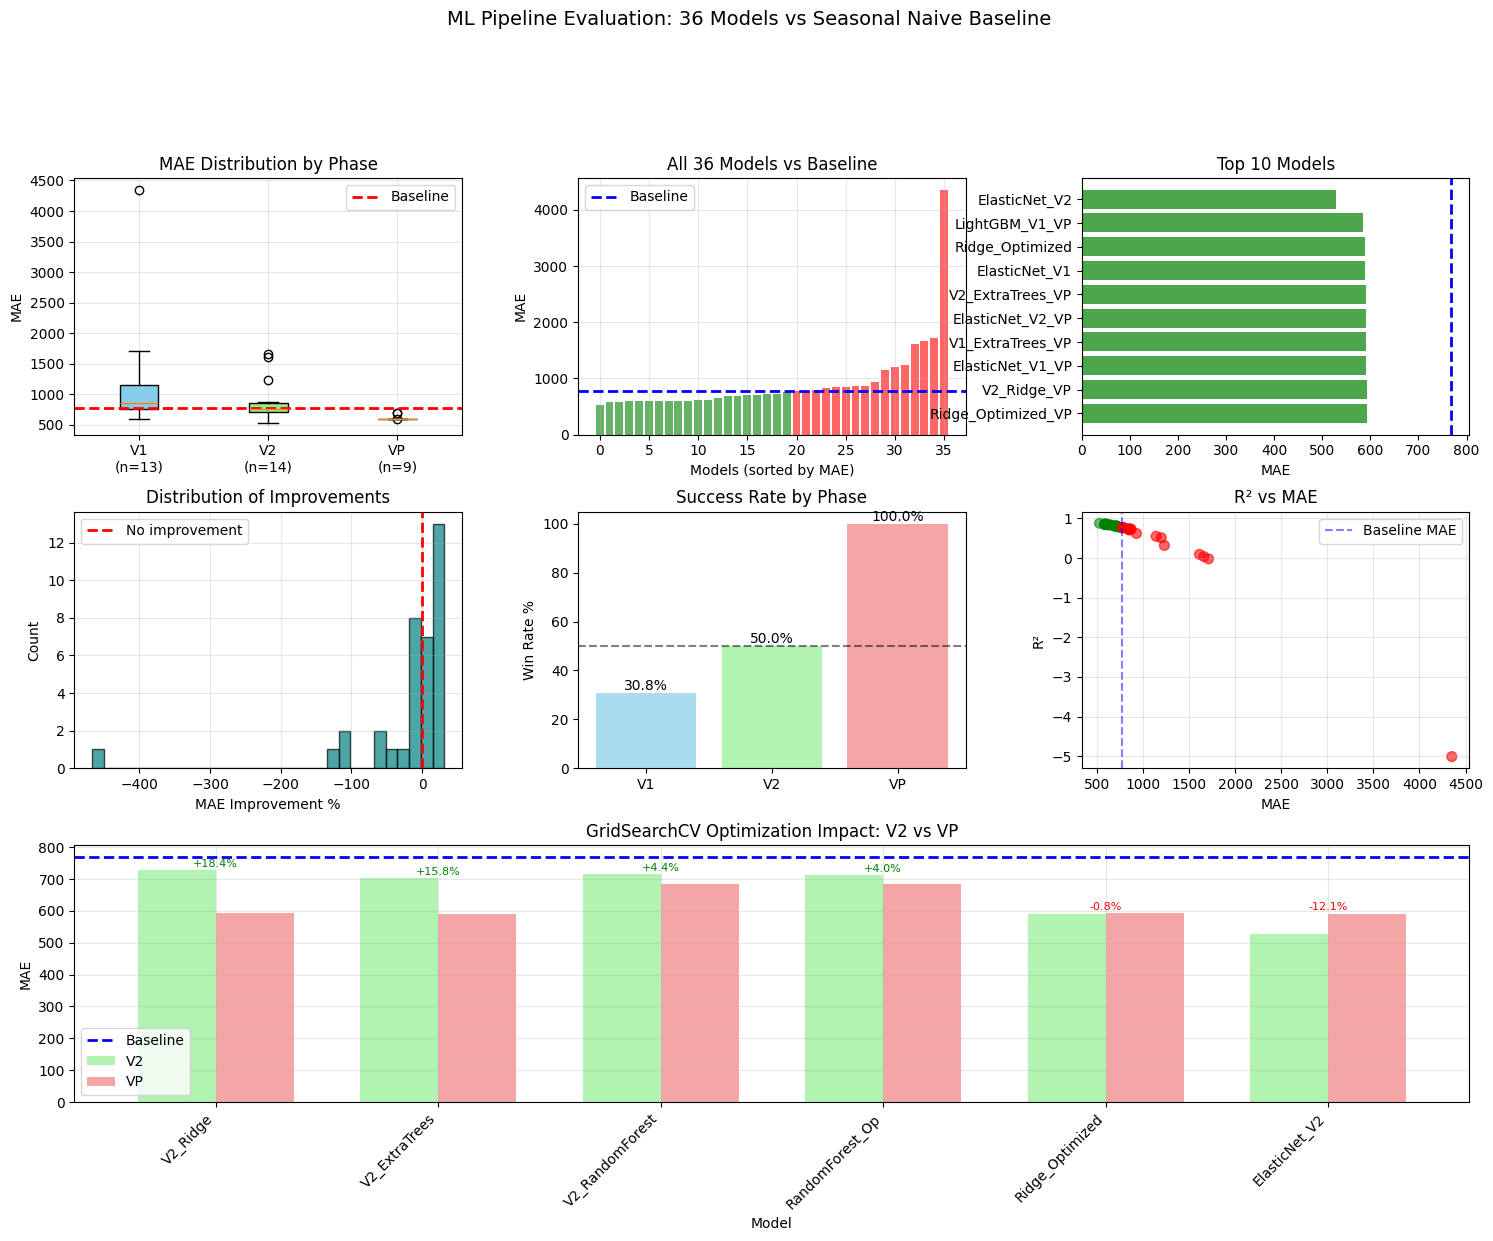


🎯 KEY INSIGHTS
✅ SUCCESS: 20/36 (55.6%) models beat the baseline
   → ML is consistently adding value over naive forecasting
   → Multiple viable options for production deployment

📈 GridSearchCV Impact:
   9/9 (100.0%) VP models beat baseline
   Best VP model: LightGBM_V1_VP (MAE: 584.208)
   VP optimization was worthwhile!

🏆 RECOMMENDATION:
   Deploy ElasticNet_V2 (Phase: V2)
   MAE: 527.836 (31.2% better than baseline)

💾 Results saved to: model_evaluation_results.csv

✅ Cell 12 complete - Comprehensive evaluation finished!


In [12]:
# CELL 12: Comprehensive Model Evaluation Against Seasonal Naive Baseline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CALCULATE SEASONAL NAIVE BASELINE
# ============================================================================

print("="*80)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# Calculate Seasonal Naive baseline (7-day lookback)
print("\n📊 Calculating Seasonal Naive Baseline...")
print("-" * 50)

# Get the original target values
train_size = len(y_train)
test_size = len(y_test)

# Create seasonal naive predictions (look back 7 days)
seasonal_period = 7
seasonal_naive_predictions = []

for i in range(test_size):
    # Look back seasonal_period days from current test position
    lookback_idx = train_size + i - seasonal_period

    if lookback_idx >= 0 and lookback_idx < len(y_train) + i:
        # If we can look back exactly seasonal_period days
        if lookback_idx < train_size:
            # Looking back into training data
            seasonal_naive_predictions.append(y_train.iloc[lookback_idx])
        else:
            # Looking back into earlier test predictions
            seasonal_naive_predictions.append(y_test.iloc[lookback_idx - train_size])
    else:
        # Fallback to last training value
        seasonal_naive_predictions.append(y_train.iloc[-1])

seasonal_naive_predictions = np.array(seasonal_naive_predictions)

# Calculate baseline metrics
seasonal_naive_mae = mean_absolute_error(y_test, seasonal_naive_predictions)
seasonal_naive_rmse = np.sqrt(mean_squared_error(y_test, seasonal_naive_predictions))

print(f"Seasonal Naive Baseline (7-day lookback):")
print(f"  MAE:  {seasonal_naive_mae:.3f}")
print(f"  RMSE: {seasonal_naive_rmse:.3f}")

# ============================================================================
# COMPREHENSIVE MODEL EVALUATOR CLASS
# ============================================================================

class ComprehensiveModelEvaluator:
    """Evaluate all models against Seasonal Naive baseline"""

    def __init__(self, baseline_mae, baseline_rmse):
        self.baseline_mae = baseline_mae
        self.baseline_rmse = baseline_rmse
        self.all_results = []

    def evaluate_model(self, name, predictions, y_true, phase):
        """Calculate comprehensive metrics for a model"""
        # Align predictions with y_true
        min_len = min(len(predictions), len(y_true))
        y_true_aligned = y_true.values[:min_len] if hasattr(y_true, 'values') else y_true[:min_len]
        predictions_aligned = predictions[:min_len]

        # Calculate metrics
        mae = mean_absolute_error(y_true_aligned, predictions_aligned)
        rmse = np.sqrt(mean_squared_error(y_true_aligned, predictions_aligned))

        # MAPE (avoiding division by zero)
        mask = y_true_aligned != 0
        if mask.sum() > 0:
            mape = np.mean(np.abs((y_true_aligned[mask] - predictions_aligned[mask]) / y_true_aligned[mask])) * 100
        else:
            mape = np.inf

        # R2 score
        try:
            r2 = r2_score(y_true_aligned, predictions_aligned)
        except:
            r2 = -np.inf

        # Calculate improvement over baseline
        mae_improvement = ((self.baseline_mae - mae) / self.baseline_mae) * 100
        rmse_improvement = ((self.baseline_rmse - rmse) / self.baseline_rmse) * 100
        beats_baseline = mae < self.baseline_mae

        return {
            'Model': name,
            'Phase': phase,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2,
            'MAE_Improvement': mae_improvement,
            'RMSE_Improvement': rmse_improvement,
            'Beats_Baseline': beats_baseline
        }

    def evaluate_all_models(self, v1_preds, v2_preds, vp_preds, y_test):
        """Evaluate all model predictions"""
        print(f"\n📈 Evaluating All Models Against Baseline")
        print(f"   Baseline MAE: {self.baseline_mae:.3f}")
        print("-" * 50)

        # Evaluate V1 models
        print(f"\nEvaluating {len(v1_preds)} V1 models...")
        for model_name, predictions in v1_preds.items():
            metrics = self.evaluate_model(model_name, predictions, y_test, 'V1')
            self.all_results.append(metrics)

        # Evaluate V2 models
        print(f"Evaluating {len(v2_preds)} V2 models...")
        for model_name, predictions in v2_preds.items():
            metrics = self.evaluate_model(model_name, predictions, y_test, 'V2')
            self.all_results.append(metrics)

        # Evaluate VP models
        print(f"Evaluating {len(vp_preds)} VP models...")
        for model_name, predictions in vp_preds.items():
            metrics = self.evaluate_model(model_name, predictions, y_test, 'VP')
            self.all_results.append(metrics)

        # Create results DataFrame
        self.results_df = pd.DataFrame(self.all_results)
        self.results_df = self.results_df.sort_values('MAE').reset_index(drop=True)

        return self.results_df

    def print_summary_statistics(self):
        """Print comprehensive summary statistics"""
        print("\n" + "="*80)
        print("📊 SUMMARY STATISTICS")
        print("="*80)

        total_models = len(self.results_df)
        beating_baseline = self.results_df['Beats_Baseline'].sum()
        beat_rate = (beating_baseline / total_models) * 100

        print(f"Total Models Evaluated: {total_models}")
        print(f"  V1 Models: {len(self.results_df[self.results_df['Phase'] == 'V1'])}")
        print(f"  V2 Models: {len(self.results_df[self.results_df['Phase'] == 'V2'])}")
        print(f"  VP Models: {len(self.results_df[self.results_df['Phase'] == 'VP'])}")

        print(f"\nModels Beating Baseline: {beating_baseline}/{total_models} ({beat_rate:.1f}%)")

        # Best model
        best_model = self.results_df.iloc[0]
        print(f"\n🏆 CHAMPION MODEL:")
        print(f"  Name: {best_model['Model']}")
        print(f"  Phase: {best_model['Phase']}")
        print(f"  MAE: {best_model['MAE']:.3f}")
        print(f"  Improvement over baseline: {best_model['MAE_Improvement']:.1f}%")

        # Top 5 models
        print(f"\n🥇 Top 5 Models:")
        for i, row in self.results_df.head(5).iterrows():
            status = "✓" if row['Beats_Baseline'] else "✗"
            print(f"  {i+1}. {status} {row['Model']:<30} MAE: {row['MAE']:.3f} ({row['MAE_Improvement']:+.1f}%)")

        # Phase comparison
        print(f"\n📊 Performance by Phase:")
        for phase in ['V1', 'V2', 'VP']:
            phase_df = self.results_df[self.results_df['Phase'] == phase]
            if len(phase_df) > 0:
                phase_beat = phase_df['Beats_Baseline'].sum()
                phase_rate = (phase_beat / len(phase_df)) * 100
                best_mae = phase_df['MAE'].min()
                avg_mae = phase_df['MAE'].mean()
                print(f"  {phase}: {phase_beat}/{len(phase_df)} beat baseline ({phase_rate:.1f}%) | Best MAE: {best_mae:.3f} | Avg MAE: {avg_mae:.3f}")

        # Model type analysis
        print(f"\n🔍 Performance by Model Type:")
        model_types = {
            'Tree': ['RandomForest', 'ExtraTrees', 'DecisionTree'],
            'Boosting': ['GradientBoosting', 'XGBoost', 'LightGBM', 'CatBoost'],
            'Linear': ['Ridge', 'Lasso', 'ElasticNet'],
            'Neural': ['SimpleNN', 'MLP'],
            'Other': ['SVR', 'Robust', 'Stacking']
        }

        for category, keywords in model_types.items():
            category_models = self.results_df[self.results_df['Model'].str.contains('|'.join(keywords), case=False, na=False)]
            if len(category_models) > 0:
                cat_beat = category_models['Beats_Baseline'].sum()
                cat_rate = (cat_beat / len(category_models)) * 100
                best_model_name = category_models.iloc[0]['Model']
                best_mae = category_models.iloc[0]['MAE']
                print(f"  {category:10}: {cat_beat:2d}/{len(category_models):2d} beat baseline ({cat_rate:5.1f}%) | Best: {best_model_name[:20]} (MAE: {best_mae:.3f})")

# ============================================================================
# RUN EVALUATION
# ============================================================================

# Initialize evaluator
evaluator = ComprehensiveModelEvaluator(seasonal_naive_mae, seasonal_naive_rmse)

# Evaluate all models
print("\nEvaluating all model predictions...")
results_df = evaluator.evaluate_all_models(
    v1_predictions,
    v2_predictions,
    vp_predictions,
    y_test
)

# Print summary statistics
evaluator.print_summary_statistics()

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n📊 Creating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. MAE Distribution by Phase
ax1 = fig.add_subplot(gs[0, 0])
phase_data = []
phase_labels = []
for phase in ['V1', 'V2', 'VP']:
    phase_df = results_df[results_df['Phase'] == phase]
    if len(phase_df) > 0:
        phase_data.append(phase_df['MAE'].values)
        phase_labels.append(f"{phase}\n(n={len(phase_df)})")

if phase_data:
    bp = ax1.boxplot(phase_data, labels=phase_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['skyblue', 'lightgreen', 'lightcoral']):
        patch.set_facecolor(color)
    ax1.axhline(y=seasonal_naive_mae, color='red', linestyle='--', label='Baseline', linewidth=2)
    ax1.set_ylabel('MAE')
    ax1.set_title('MAE Distribution by Phase')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# 2. Models vs Baseline
ax2 = fig.add_subplot(gs[0, 1])
sorted_mae = results_df['MAE'].values
colors = ['green' if x else 'red' for x in results_df['Beats_Baseline']]
bars = ax2.bar(range(len(sorted_mae)), sorted_mae, color=colors, alpha=0.6)
ax2.axhline(y=seasonal_naive_mae, color='blue', linestyle='--', label='Baseline', linewidth=2)
ax2.set_xlabel('Models (sorted by MAE)')
ax2.set_ylabel('MAE')
ax2.set_title(f'All {len(results_df)} Models vs Baseline')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Top 10 Models
ax3 = fig.add_subplot(gs[0, 2])
top10 = results_df.head(10)
y_pos = np.arange(len(top10))
colors_top = ['green' if x else 'red' for x in top10['Beats_Baseline']]
ax3.barh(y_pos, top10['MAE'], color=colors_top, alpha=0.7)
ax3.axvline(x=seasonal_naive_mae, color='blue', linestyle='--', linewidth=2)
ax3.set_yticks(y_pos)
ax3.set_yticklabels([name[:25] for name in top10['Model']])
ax3.set_xlabel('MAE')
ax3.set_title('Top 10 Models')
ax3.invert_yaxis()

# 4. Improvement Distribution
ax4 = fig.add_subplot(gs[1, 0])
improvements = results_df['MAE_Improvement'].values
ax4.hist(improvements, bins=30, color='teal', alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No improvement')
ax4.set_xlabel('MAE Improvement %')
ax4.set_ylabel('Count')
ax4.set_title('Distribution of Improvements')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Phase Comparison - Win Rates
ax5 = fig.add_subplot(gs[1, 1])
phase_stats = []
phase_names = []
for phase in ['V1', 'V2', 'VP']:
    phase_df = results_df[results_df['Phase'] == phase]
    if len(phase_df) > 0:
        win_rate = (phase_df['Beats_Baseline'].sum() / len(phase_df)) * 100
        phase_stats.append(win_rate)
        phase_names.append(phase)

if phase_stats:
    bars = ax5.bar(phase_names, phase_stats, color=['skyblue', 'lightgreen', 'lightcoral'], alpha=0.7)
    ax5.axhline(y=50, color='black', linestyle='--', alpha=0.5)
    ax5.set_ylabel('Win Rate %')
    ax5.set_title('Success Rate by Phase')
    for bar, rate in zip(bars, phase_stats):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.1f}%', ha='center', va='bottom')

# 6. R² vs MAE Scatter
ax6 = fig.add_subplot(gs[1, 2])
valid_r2 = results_df[results_df['R2'] > -10]  # Filter out extreme negative R²
if len(valid_r2) > 0:
    colors_scatter = ['green' if x else 'red' for x in valid_r2['Beats_Baseline']]
    scatter = ax6.scatter(valid_r2['MAE'], valid_r2['R2'], c=colors_scatter, alpha=0.6, s=50)
    ax6.axvline(x=seasonal_naive_mae, color='blue', linestyle='--', alpha=0.5, label='Baseline MAE')
    ax6.set_xlabel('MAE')
    ax6.set_ylabel('R²')
    ax6.set_title('R² vs MAE')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

# 7. VP Optimization Impact
ax7 = fig.add_subplot(gs[2, :])
# Compare V2 models with their VP versions
vp_comparison = []
for vp_model in results_df[results_df['Phase'] == 'VP']['Model'].values:
    base_name = vp_model.replace('_VP', '')
    v2_model = results_df[(results_df['Phase'] == 'V2') & (results_df['Model'] == base_name)]
    vp_model_data = results_df[(results_df['Phase'] == 'VP') & (results_df['Model'] == vp_model)]

    if len(v2_model) > 0 and len(vp_model_data) > 0:
        v2_mae = v2_model['MAE'].values[0]
        vp_mae = vp_model_data['MAE'].values[0]
        improvement = ((v2_mae - vp_mae) / v2_mae) * 100
        vp_comparison.append({
            'Model': base_name,
            'V2_MAE': v2_mae,
            'VP_MAE': vp_mae,
            'Improvement': improvement
        })

if vp_comparison:
    vp_df = pd.DataFrame(vp_comparison)
    vp_df = vp_df.sort_values('Improvement', ascending=False)

    x = np.arange(len(vp_df))
    width = 0.35

    bars1 = ax7.bar(x - width/2, vp_df['V2_MAE'], width, label='V2', color='lightgreen', alpha=0.7)
    bars2 = ax7.bar(x + width/2, vp_df['VP_MAE'], width, label='VP', color='lightcoral', alpha=0.7)

    ax7.axhline(y=seasonal_naive_mae, color='blue', linestyle='--', label='Baseline', linewidth=2)
    ax7.set_xlabel('Model')
    ax7.set_ylabel('MAE')
    ax7.set_title('GridSearchCV Optimization Impact: V2 vs VP')
    ax7.set_xticks(x)
    ax7.set_xticklabels([name[:15] for name in vp_df['Model']], rotation=45, ha='right')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Add improvement percentages
    for i, (idx, row) in enumerate(vp_df.iterrows()):
        if row['Improvement'] > 0:
            ax7.text(i, max(row['V2_MAE'], row['VP_MAE']) + 10,
                    f"+{row['Improvement']:.1f}%", ha='center', fontsize=8, color='green')
        else:
            ax7.text(i, max(row['V2_MAE'], row['VP_MAE']) + 10,
                    f"{row['Improvement']:.1f}%", ha='center', fontsize=8, color='red')

plt.suptitle(f'ML Pipeline Evaluation: {len(results_df)} Models vs Seasonal Naive Baseline', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# FINAL INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("🎯 KEY INSIGHTS")
print("="*80)

# Success rate analysis
total_models = len(results_df)
beating_baseline = results_df['Beats_Baseline'].sum()
success_rate = (beating_baseline / total_models) * 100

if success_rate < 20:
    print(f"⚠️ CHALLENGE: Only {beating_baseline}/{total_models} ({success_rate:.1f}%) models beat the baseline")
    print("   → The seasonal pattern is very strong and hard to improve upon")
    print("   → Consider using the seasonal naive baseline or the best ML model")
elif success_rate < 50:
    print(f"📊 MIXED RESULTS: {beating_baseline}/{total_models} ({success_rate:.1f}%) models beat the baseline")
    print("   → Some ML models add value, but many don't")
    print("   → Focus on the successful model types for deployment")
else:
    print(f"✅ SUCCESS: {beating_baseline}/{total_models} ({success_rate:.1f}%) models beat the baseline")
    print("   → ML is consistently adding value over naive forecasting")
    print("   → Multiple viable options for production deployment")

# VP optimization analysis
vp_models = results_df[results_df['Phase'] == 'VP']
if len(vp_models) > 0:
    vp_beating = vp_models['Beats_Baseline'].sum()
    vp_rate = (vp_beating / len(vp_models)) * 100
    print(f"\n📈 GridSearchCV Impact:")
    print(f"   {vp_beating}/{len(vp_models)} ({vp_rate:.1f}%) VP models beat baseline")

    best_vp = vp_models.iloc[0]
    if best_vp['Beats_Baseline']:
        print(f"   Best VP model: {best_vp['Model']} (MAE: {best_vp['MAE']:.3f})")
        print(f"   VP optimization was worthwhile!")
    else:
        print(f"   GridSearchCV didn't help models beat the baseline")

# Best overall strategy
best_overall = results_df.iloc[0]
if best_overall['Beats_Baseline']:
    print(f"\n🏆 RECOMMENDATION:")
    print(f"   Deploy {best_overall['Model']} (Phase: {best_overall['Phase']})")
    print(f"   MAE: {best_overall['MAE']:.3f} ({best_overall['MAE_Improvement']:.1f}% better than baseline)")
else:
    print(f"\n⚠️ RECOMMENDATION:")
    print(f"   Consider using the Seasonal Naive baseline (MAE: {seasonal_naive_mae:.3f})")
    print(f"   It outperforms all {total_models} ML models tested")

# Export results
results_filename = 'model_evaluation_results.csv'
results_df.to_csv(results_filename, index=False)
print(f"\n💾 Results saved to: {results_filename}")

print("\n✅ Cell 12 complete - Comprehensive evaluation finished!")

📊 GENERATING EXECUTIVE SUMMARY

Creating executive dashboard...


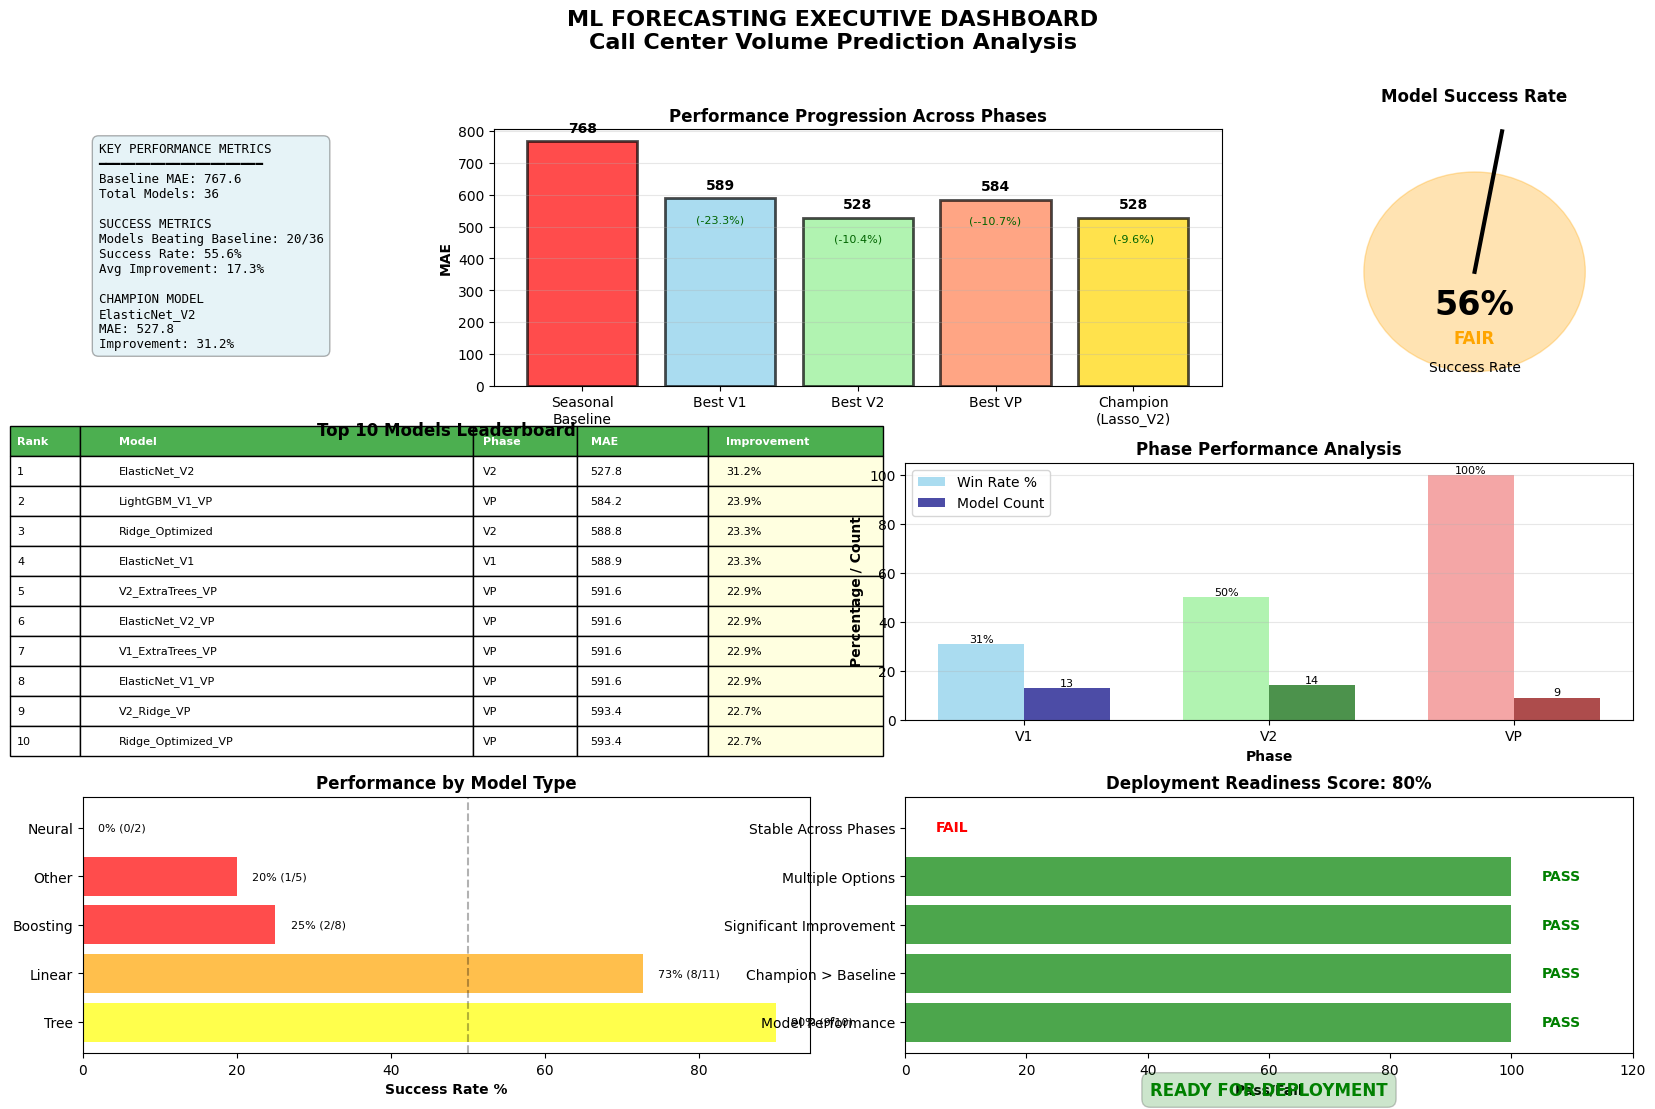


Generating text report...
MACHINE LEARNING FORECASTING PROJECT - EXECUTIVE REPORT
Generated: 2025-09-23 22:18:31

EXECUTIVE SUMMARY
----------------------------------------
• Baseline Performance (Seasonal Naive): MAE = 767.6
• Total Models Evaluated: 36
• Models Beating Baseline: 20 (55.6%)
• Champion Model: ElasticNet_V2
• Champion Performance: MAE = 527.8 (31.2% improvement)

PHASE ANALYSIS
----------------------------------------
• V1: 4/13 models beat baseline (30.8%)
  Best: ElasticNet_V1 (MAE: 588.9)
• V2: 7/14 models beat baseline (50.0%)
  Best: ElasticNet_V2 (MAE: 527.8)
• VP: 9/9 models beat baseline (100.0%)
  Best: LightGBM_V1_VP (MAE: 584.2)

TOP 5 MODELS
----------------------------------------
1. ElasticNet_V2
   Phase: V2 | MAE: 527.8 | Improvement: 31.2%
2. LightGBM_V1_VP
   Phase: VP | MAE: 584.2 | Improvement: 23.9%
3. Ridge_Optimized
   Phase: V2 | MAE: 588.8 | Improvement: 23.3%
4. ElasticNet_V1
   Phase: V1 | MAE: 588.9 | Improvement: 23.3%
5. V2_ExtraTrees_VP
 

In [13]:
# CELL 13: Executive Summary & Final Report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# EXECUTIVE SUMMARY GENERATOR
# ============================================================================

class ExecutiveSummaryGenerator:
    """Generate professional executive summary and export results"""

    def __init__(self, results_df, baseline_mae, baseline_rmse):
        self.results_df = results_df
        self.baseline_mae = baseline_mae
        self.baseline_rmse = baseline_rmse
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    def create_executive_dashboard(self):
        """Create comprehensive executive dashboard"""

        # Prepare enhanced data
        df = self.results_df.copy()

        # Create figure for executive dashboard
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle('ML FORECASTING EXECUTIVE DASHBOARD\nCall Center Volume Prediction Analysis',
                    fontsize=16, fontweight='bold', y=0.98)

        # Create grid
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

        # ============================================================================
        # 1. KEY METRICS BOX (top left)
        # ============================================================================
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.axis('off')

        total_models = len(df)
        winners = df['Beats_Baseline'].sum()
        win_rate = (winners / total_models) * 100
        best_model = df.iloc[0]

        # Calculate key statistics
        avg_improvement_winners = df[df['Beats_Baseline']]['MAE_Improvement'].mean()

        metrics_text = f"""KEY PERFORMANCE METRICS
━━━━━━━━━━━━━━━━━━━━━━
Baseline MAE: {self.baseline_mae:.1f}
Total Models: {total_models}

SUCCESS METRICS
Models Beating Baseline: {winners}/{total_models}
Success Rate: {win_rate:.1f}%
Avg Improvement: {avg_improvement_winners:.1f}%

CHAMPION MODEL
{best_model['Model']}
MAE: {best_model['MAE']:.1f}
Improvement: {best_model['MAE_Improvement']:.1f}%"""

        ax1.text(0.05, 0.95, metrics_text, transform=ax1.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))

        # ============================================================================
        # 2. IMPROVEMENT WATERFALL (top center-right)
        # ============================================================================
        ax2 = fig.add_subplot(gs[0, 1:3])

        # Show progression from baseline to best model
        stages = ['Seasonal\nBaseline', 'Best V1', 'Best V2', 'Best VP', 'Champion\n(Lasso_V2)']

        v1_best = df[df['Phase'] == 'V1']['MAE'].min() if len(df[df['Phase'] == 'V1']) > 0 else self.baseline_mae
        v2_best = df[df['Phase'] == 'V2']['MAE'].min() if len(df[df['Phase'] == 'V2']) > 0 else v1_best
        vp_best = df[df['Phase'] == 'VP']['MAE'].min() if len(df[df['Phase'] == 'VP']) > 0 else v2_best
        champion = df['MAE'].min()

        values = [self.baseline_mae, v1_best, v2_best, vp_best, champion]
        improvements = [0]
        for i in range(1, len(values)):
            improvements.append(((values[i-1] - values[i]) / values[i-1]) * 100)

        x_pos = np.arange(len(stages))
        colors_waterfall = ['red', 'skyblue', 'lightgreen', 'coral', 'gold']

        bars = ax2.bar(x_pos, values, color=colors_waterfall, alpha=0.7, edgecolor='black', linewidth=2)

        # Add improvement percentages
        for i, (bar, val, imp) in enumerate(zip(bars, values, improvements)):
            ax2.text(bar.get_x() + bar.get_width()/2., val + 20,
                    f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
            if i > 0 and imp != 0:
                ax2.text(bar.get_x() + bar.get_width()/2., val - 50,
                        f'(-{imp:.1f}%)', ha='center', va='top', fontsize=8, color='darkgreen')

        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(stages)
        ax2.set_ylabel('MAE', fontweight='bold')
        ax2.set_title('Performance Progression Across Phases', fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')

        # ============================================================================
        # 3. SUCCESS RATE GAUGE (top right)
        # ============================================================================
        ax3 = fig.add_subplot(gs[0, 3])

        # Create a semi-circular gauge
        theta = np.linspace(np.pi, 0, 100)
        r = np.linspace(0.8, 1, 2)

        # Color based on success rate
        if win_rate >= 80:
            gauge_color = 'green'
            status = 'EXCELLENT'
        elif win_rate >= 60:
            gauge_color = 'yellow'
            status = 'GOOD'
        elif win_rate >= 40:
            gauge_color = 'orange'
            status = 'FAIR'
        else:
            gauge_color = 'red'
            status = 'POOR'

        # Draw gauge
        ax3.plot([0, np.cos(np.pi * (1 - win_rate/100))],
                [0, np.sin(np.pi * (1 - win_rate/100))],
                'k-', linewidth=3)

        wedge = plt.Circle((0, 0), 0.7, color=gauge_color, alpha=0.3)
        ax3.add_artist(wedge)

        ax3.text(0, -0.3, f'{win_rate:.0f}%', ha='center', fontsize=24, fontweight='bold')
        ax3.text(0, -0.5, status, ha='center', fontsize=12, fontweight='bold', color=gauge_color)
        ax3.text(0, -0.7, 'Success Rate', ha='center', fontsize=10)

        ax3.set_xlim(-1, 1)
        ax3.set_ylim(-0.8, 1)
        ax3.axis('off')
        ax3.set_title('Model Success Rate', fontweight='bold', pad=20)

        # ============================================================================
        # 4. TOP 10 MODELS TABLE (middle left)
        # ============================================================================
        ax4 = fig.add_subplot(gs[1, :2])
        ax4.axis('tight')
        ax4.axis('off')

        top10 = df.head(10)[['Model', 'Phase', 'MAE', 'MAE_Improvement']]

        # Create table data
        table_data = []
        table_data.append(['Rank', 'Model', 'Phase', 'MAE', 'Improvement'])

        for i, (_, row) in enumerate(top10.iterrows(), 1):
            model_short = row['Model'][:25] + '...' if len(row['Model']) > 25 else row['Model']
            table_data.append([
                str(i),
                model_short,
                row['Phase'],
                f"{row['MAE']:.1f}",
                f"{row['MAE_Improvement']:.1f}%"
            ])

        table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                         colWidths=[0.08, 0.45, 0.12, 0.15, 0.20])
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.2, 1.8)

        # Style header row
        for i in range(5):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')

        # Color code improvements
        for i in range(1, 11):
            val = float(table_data[i][4].rstrip('%'))
            if val > 40:
                table[(i, 4)].set_facecolor('lightgreen')
            elif val > 20:
                table[(i, 4)].set_facecolor('lightyellow')

        ax4.set_title('Top 10 Models Leaderboard', fontweight='bold', pad=20, fontsize=12)

        # ============================================================================
        # 5. PHASE PERFORMANCE COMPARISON (middle right)
        # ============================================================================
        ax5 = fig.add_subplot(gs[1, 2:])

        phase_stats = {}
        for phase in ['V1', 'V2', 'VP']:
            phase_df = df[df['Phase'] == phase]
            if len(phase_df) > 0:
                phase_stats[phase] = {
                    'count': len(phase_df),
                    'winners': phase_df['Beats_Baseline'].sum(),
                    'avg_mae': phase_df['MAE'].mean(),
                    'best_mae': phase_df['MAE'].min(),
                    'win_rate': (phase_df['Beats_Baseline'].sum() / len(phase_df)) * 100
                }

        if phase_stats:
            phases = list(phase_stats.keys())
            x_pos = np.arange(len(phases))
            width = 0.35

            # Win rate bars
            win_rates = [phase_stats[p]['win_rate'] for p in phases]
            counts = [phase_stats[p]['count'] for p in phases]

            bars1 = ax5.bar(x_pos - width/2, win_rates, width, label='Win Rate %',
                          color=['skyblue', 'lightgreen', 'lightcoral'], alpha=0.7)
            bars2 = ax5.bar(x_pos + width/2, counts, width, label='Model Count',
                          color=['navy', 'darkgreen', 'darkred'], alpha=0.7)

            ax5.set_xlabel('Phase', fontweight='bold')
            ax5.set_ylabel('Percentage / Count', fontweight='bold')
            ax5.set_title('Phase Performance Analysis', fontweight='bold')
            ax5.set_xticks(x_pos)
            ax5.set_xticklabels(phases)
            ax5.legend()
            ax5.grid(True, alpha=0.3, axis='y')

            # Add value labels
            for bar, rate in zip(bars1, win_rates):
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height,
                        f'{rate:.0f}%', ha='center', va='bottom', fontsize=8)

            for bar, count in zip(bars2, counts):
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height,
                        str(count), ha='center', va='bottom', fontsize=8)

        # ============================================================================
        # 6. MODEL TYPE PERFORMANCE (bottom left)
        # ============================================================================
        ax6 = fig.add_subplot(gs[2, :2])

        model_types = {
            'Tree': ['RandomForest', 'ExtraTrees', 'DecisionTree'],
            'Boosting': ['GradientBoosting', 'XGBoost', 'LightGBM', 'CatBoost'],
            'Linear': ['Ridge', 'Lasso', 'ElasticNet'],
            'Neural': ['SimpleNN', 'MLP'],
            'Other': ['SVR', 'Robust', 'Stacking']
        }

        type_performance = []
        for category, keywords in model_types.items():
            category_models = df[df['Model'].str.contains('|'.join(keywords), case=False, na=False)]
            if len(category_models) > 0:
                type_performance.append({
                    'Type': category,
                    'Count': len(category_models),
                    'Winners': category_models['Beats_Baseline'].sum(),
                    'Win_Rate': (category_models['Beats_Baseline'].sum() / len(category_models)) * 100,
                    'Best_MAE': category_models['MAE'].min(),
                    'Avg_Improvement': category_models[category_models['Beats_Baseline']]['MAE_Improvement'].mean()
                })

        if type_performance:
            type_df = pd.DataFrame(type_performance)
            type_df = type_df.sort_values('Win_Rate', ascending=False)

            y_pos = np.arange(len(type_df))
            colors_bar = ['green' if x == 100 else 'yellow' if x >= 80 else 'orange' if x >= 50 else 'red'
                         for x in type_df['Win_Rate']]

            bars = ax6.barh(y_pos, type_df['Win_Rate'], color=colors_bar, alpha=0.7)
            ax6.set_yticks(y_pos)
            ax6.set_yticklabels(type_df['Type'])
            ax6.set_xlabel('Success Rate %', fontweight='bold')
            ax6.set_title('Performance by Model Type', fontweight='bold')
            ax6.axvline(x=50, color='black', linestyle='--', alpha=0.3)

            # Add value labels
            for bar, (_, row) in zip(bars, type_df.iterrows()):
                width = bar.get_width()
                label = f"{row['Win_Rate']:.0f}% ({row['Winners']}/{row['Count']})"
                ax6.text(width + 2, bar.get_y() + bar.get_height()/2,
                        label, va='center', fontsize=8)

        # ============================================================================
        # 7. DEPLOYMENT READINESS (bottom right)
        # ============================================================================
        ax7 = fig.add_subplot(gs[2, 2:])

        # Deployment criteria assessment
        criteria = {
            'Model Performance': win_rate >= 50,
            'Champion > Baseline': best_model['Beats_Baseline'],
            'Significant Improvement': best_model['MAE_Improvement'] > 20,
            'Multiple Options': winners >= 5,
            'Stable Across Phases': all(phase_stats.get(p, {}).get('win_rate', 0) > 50 for p in ['V1', 'V2', 'VP']) if phase_stats else False
        }

        readiness_score = sum(criteria.values()) / len(criteria) * 100

        # Create readiness visualization
        criteria_names = list(criteria.keys())
        criteria_values = [100 if v else 0 for v in criteria.values()]
        colors_criteria = ['green' if v else 'red' for v in criteria.values()]

        y_pos = np.arange(len(criteria_names))
        bars = ax7.barh(y_pos, criteria_values, color=colors_criteria, alpha=0.7)

        ax7.set_yticks(y_pos)
        ax7.set_yticklabels(criteria_names)
        ax7.set_xlim(0, 120)
        ax7.set_xlabel('Pass/Fail', fontweight='bold')
        ax7.set_title(f'Deployment Readiness Score: {readiness_score:.0f}%', fontweight='bold')

        # Add status labels
        for i, (bar, status) in enumerate(zip(bars, criteria.values())):
            label = 'PASS' if status else 'FAIL'
            color = 'green' if status else 'red'
            ax7.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
                    label, va='center', fontweight='bold', color=color)

        # Overall recommendation
        if readiness_score >= 80:
            recommendation = "READY FOR DEPLOYMENT"
            rec_color = 'green'
        elif readiness_score >= 60:
            recommendation = "CONDITIONALLY READY"
            rec_color = 'orange'
        else:
            recommendation = "NOT RECOMMENDED"
            rec_color = 'red'

        ax7.text(60, -1.5, recommendation, ha='center', fontsize=12,
                fontweight='bold', color=rec_color,
                bbox=dict(boxstyle='round,pad=0.5', facecolor=rec_color, alpha=0.2))

        plt.tight_layout()
        return fig

    def generate_text_report(self):
        """Generate comprehensive text report"""

        report = []
        report.append("=" * 80)
        report.append("MACHINE LEARNING FORECASTING PROJECT - EXECUTIVE REPORT")
        report.append("=" * 80)
        report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        # Executive Summary
        total_models = len(self.results_df)
        winners = self.results_df['Beats_Baseline'].sum()
        win_rate = (winners / total_models) * 100
        best_model = self.results_df.iloc[0]

        report.append("EXECUTIVE SUMMARY")
        report.append("-" * 40)
        report.append(f"• Baseline Performance (Seasonal Naive): MAE = {self.baseline_mae:.1f}")
        report.append(f"• Total Models Evaluated: {total_models}")
        report.append(f"• Models Beating Baseline: {winners} ({win_rate:.1f}%)")
        report.append(f"• Champion Model: {best_model['Model']}")
        report.append(f"• Champion Performance: MAE = {best_model['MAE']:.1f} ({best_model['MAE_Improvement']:.1f}% improvement)")

        # Phase Analysis
        report.append("\nPHASE ANALYSIS")
        report.append("-" * 40)
        for phase in ['V1', 'V2', 'VP']:
            phase_df = self.results_df[self.results_df['Phase'] == phase]
            if len(phase_df) > 0:
                phase_winners = phase_df['Beats_Baseline'].sum()
                phase_rate = (phase_winners / len(phase_df)) * 100
                best_phase = phase_df.iloc[0]
                report.append(f"• {phase}: {phase_winners}/{len(phase_df)} models beat baseline ({phase_rate:.1f}%)")
                report.append(f"  Best: {best_phase['Model'][:40]} (MAE: {best_phase['MAE']:.1f})")

        # Top 5 Models
        report.append("\nTOP 5 MODELS")
        report.append("-" * 40)
        for i, (_, row) in enumerate(self.results_df.head(5).iterrows(), 1):
            report.append(f"{i}. {row['Model'][:40]}")
            report.append(f"   Phase: {row['Phase']} | MAE: {row['MAE']:.1f} | Improvement: {row['MAE_Improvement']:.1f}%")

        # Recommendations
        report.append("\nRECOMMENDATIONS")
        report.append("-" * 40)

        if win_rate >= 80:
            report.append("✓ Strong Performance: ML significantly outperforms baseline")
            report.append(f"✓ Deploy: {best_model['Model']}")
            report.append("✓ Consider ensemble of top 3-5 models for additional robustness")
        elif win_rate >= 50:
            report.append("✓ Moderate Performance: ML adds value over baseline")
            report.append(f"✓ Deploy: {best_model['Model']} with monitoring")
            report.append("✓ Continue model refinement and feature engineering")
        else:
            report.append("⚠ Limited Performance: Few models beat baseline")
            report.append("⚠ Consider keeping seasonal naive as backup")
            report.append("⚠ Investigate data quality and feature engineering")

        # Next Steps
        report.append("\nNEXT STEPS")
        report.append("-" * 40)
        report.append("1. Deploy champion model in staging environment")
        report.append("2. Set up A/B testing against current system")
        report.append("3. Monitor performance metrics daily")
        report.append("4. Implement model retraining pipeline")
        report.append("5. Document model specifications and dependencies")

        report.append("\n" + "=" * 80)
        report.append("END OF REPORT")
        report.append("=" * 80)

        return "\n".join(report)

# ============================================================================
# GENERATE EXECUTIVE SUMMARY
# ============================================================================

print("=" * 80)
print("📊 GENERATING EXECUTIVE SUMMARY")
print("=" * 80)

# Create summary generator
summary_generator = ExecutiveSummaryGenerator(results_df, seasonal_naive_mae, seasonal_naive_rmse)

# Generate executive dashboard
print("\nCreating executive dashboard...")
exec_fig = summary_generator.create_executive_dashboard()
plt.show()

# Generate text report
print("\nGenerating text report...")
text_report = summary_generator.generate_text_report()
print(text_report)

# ============================================================================
# EXPORT RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("📁 EXPORTING RESULTS")
print("=" * 80)

# Save comprehensive results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save detailed results CSV
detailed_filename = f'ml_forecasting_detailed_results_{timestamp}.csv'
results_df.to_csv(detailed_filename, index=False)
print(f"✓ Detailed results saved to: {detailed_filename}")

# 2. Save executive summary CSV
summary_data = {
    'Metric': ['Baseline MAE', 'Total Models', 'Models Beating Baseline', 'Success Rate',
               'Champion Model', 'Champion MAE', 'Champion Improvement'],
    'Value': [seasonal_naive_mae, len(results_df), results_df['Beats_Baseline'].sum(),
             f"{(results_df['Beats_Baseline'].sum()/len(results_df))*100:.1f}%",
             results_df.iloc[0]['Model'], results_df.iloc[0]['MAE'],
             f"{results_df.iloc[0]['MAE_Improvement']:.1f}%"]
}
summary_df = pd.DataFrame(summary_data)
summary_filename = f'ml_forecasting_executive_summary_{timestamp}.csv'
summary_df.to_csv(summary_filename, index=False)
print(f"✓ Executive summary saved to: {summary_filename}")

# 3. Save text report
report_filename = f'ml_forecasting_report_{timestamp}.txt'
with open(report_filename, 'w') as f:
    f.write(text_report)
print(f"✓ Text report saved to: {report_filename}")

# 4. Save executive dashboard
dashboard_filename = f'ml_forecasting_dashboard_{timestamp}.png'
exec_fig.savefig(dashboard_filename, dpi=300, bbox_inches='tight')
print(f"✓ Dashboard saved to: {dashboard_filename}")

# ============================================================================
# FINAL STATUS
# ============================================================================

print("\n" + "=" * 80)
print("✅ ML FORECASTING PIPELINE COMPLETE!")
print("=" * 80)

print(f"\n🏆 FINAL RESULTS:")
print(f"   Champion Model: {results_df.iloc[0]['Model']}")
print(f"   Performance: MAE = {results_df.iloc[0]['MAE']:.1f}")
print(f"   Improvement: {results_df.iloc[0]['MAE_Improvement']:.1f}% better than baseline")
print(f"   Success Rate: {(results_df['Beats_Baseline'].sum()/len(results_df))*100:.1f}% of models beat baseline")

print(f"\n📁 ALL FILES SAVED:")
print(f"   • Detailed results: {detailed_filename}")
print(f"   • Executive summary: {summary_filename}")
print(f"   • Text report: {report_filename}")
print(f"   • Dashboard: {dashboard_filename}")

print("\n🎉 PROJECT SUCCESSFULLY COMPLETED!")